<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/ITERATION_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-u44z56gx
  Entered build tracker: /tmp/pip-build-tracker-u44z56gx
  Created temporary directory: /tmp/pip-install-ft_87p_d
  Created temporary directory: /tmp/pip-ephem-wheel-cache-ebcegc6s
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.2 MB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [26]:
costs = []
errors = []

In [27]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [28]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']
Llama.generate: prefix-match hit


Iteration 1: Best Cost = 64319.4654841783
w1 = 0.42
Iteration 2: Best Cost = 51510.77377547067


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 41130.963728577306


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 31100.420282520136


Llama.generate: prefix-match hit


w4 = 0.24
Iteration 5: Best Cost = 22943.513154430122


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = 14816.88431731401


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = 6935.143905617257


Llama.generate: prefix-match hit


w7 = 0.163
Iteration 8: Best Cost = 5864.317000757508


Llama.generate: prefix-match hit


w8 = 0.145
Iteration 9: Best Cost = 5249.05732568526


Llama.generate: prefix-match hit


w9 = 0.137
Iteration 10: Best Cost = 4196.206110244803


Llama.generate: prefix-match hit


w10 = 0.129
Iteration 11: Best Cost = 2047.766825964238


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 1233.8672864608227


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 1233.8672864608227


Llama.generate: prefix-match hit


w13 = 0.104
Iteration 14: Best Cost = 1233.8672864608227


Llama.generate: prefix-match hit


w14 = 0.097
Iteration 15: Best Cost = 766.6023686952899


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 166.72630777113045


Llama.generate: prefix-match hit


w16 = 0.076
Iteration 17: Best Cost = 65.34137972941198


Llama.generate: prefix-match hit


w17 = 0.083
Iteration 18: Best Cost = -61.090806591284036


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = -61.090806591284036


Llama.generate: prefix-match hit


w19 = 0.084
Iteration 20: Best Cost = -61.090806591284036


Llama.generate: prefix-match hit


w20 = 0.096
Iteration 21: Best Cost = -305.0522991479759


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = -456.7031525028142
Iteration 23: Best Cost = -456.7031525028142
Iteration 24: Best Cost = -557.9751448820994
Iteration 25: Best Cost = -557.9751448820994
Iteration 26: Best Cost = -636.9586819172591
Iteration 27: Best Cost = -636.9586819172591
Iteration 28: Best Cost = -736.2700941905808
Iteration 29: Best Cost = -799.6546512652928
Iteration 30: Best Cost = -799.6546512652928
Iteration 31: Best Cost = -799.6546512652928
Iteration 32: Best Cost = -799.6546512652928
Iteration 33: Best Cost = -799.6546512652928
Iteration 34: Best Cost = -888.2095835038657
Iteration 35: Best Cost = -917.0571078904117
Iteration 36: Best Cost = -917.0571078904117
Iteration 37: Best Cost = -917.0571078904117
Iteration 38: Best Cost = -917.0571078904117
Iteration 39: Best Cost = -931.1595009532418
Iteration 40: Best Cost = -966.2478026588249
Iteration 41: Best Cost = -966.2478026588249
Iteration 42: Best Cost = -966.2478026588249
Iteration 43: Best Cost = -980.468107313235

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = -701.4223087656527


Llama.generate: prefix-match hit


w2 = 0.2438976935
Iteration 3: Best Cost = -701.430954095175


Llama.generate: prefix-match hit


w3 = 0.2178976935
Iteration 4: Best Cost = -701.4658097520413


Llama.generate: prefix-match hit


w4 = 0.1942778594
Iteration 5: Best Cost = -701.4807908716535


Llama.generate: prefix-match hit


w5 = 0.1638294231
Iteration 6: Best Cost = -701.5164878790657


Llama.generate: prefix-match hit


w6 = 0.1576289231
Iteration 7: Best Cost = -701.5524898390083


Llama.generate: prefix-match hit


w7 = 0.14526875
Iteration 8: Best Cost = -701.5714343395589


Llama.generate: prefix-match hit


w8 = 0.13912345
Iteration 9: Best Cost = -701.5714343395589


Llama.generate: prefix-match hit


w9 = 0.12876543
Iteration 10: Best Cost = -701.5877833714237


Llama.generate: prefix-match hit


w10 = 0.12092168
Iteration 11: Best Cost = -701.6215648515442


Llama.generate: prefix-match hit


w11 = 0.11734512
Iteration 12: Best Cost = -701.6353534231116


Llama.generate: prefix-match hit


w12 = 0.11689511
Iteration 13: Best Cost = -701.6356632795096


Llama.generate: prefix-match hit


w13 = 0.1134725
Iteration 14: Best Cost = -701.6578614988669


Llama.generate: prefix-match hit


w14 = 0.1098678
Iteration 15: Best Cost = -701.6644050601853


Llama.generate: prefix-match hit


w15 = 0.0943258
Iteration 16: Best Cost = -701.6684305819056


Llama.generate: prefix-match hit


w16 = 0.0876271
Iteration 17: Best Cost = -701.6699378363871


Llama.generate: prefix-match hit


w17 = 0.0934567
Iteration 18: Best Cost = -701.7018829479221


Llama.generate: prefix-match hit


w18 = 0.0825
Iteration 19: Best Cost = -701.7041547673809


Llama.generate: prefix-match hit


w19 = 0.0769
Iteration 20: Best Cost = -701.7138072833353


Llama.generate: prefix-match hit


w20 = 0.0684
Iteration 21: Best Cost = -701.7138072833353


Llama.generate: prefix-match hit


w21 = 0.0753
Iteration 22: Best Cost = -701.724796053412
Iteration 23: Best Cost = -701.7483464270555
Iteration 24: Best Cost = -701.7483464270555
Iteration 25: Best Cost = -701.7609252258145
Iteration 26: Best Cost = -701.7609252258145
Iteration 27: Best Cost = -701.7609252258145
Iteration 28: Best Cost = -701.76851276991
Iteration 29: Best Cost = -701.76851276991
Iteration 30: Best Cost = -701.7875417180023
Iteration 31: Best Cost = -701.7980844477789
Iteration 32: Best Cost = -701.8036098797431
Iteration 33: Best Cost = -701.8036098797431
Iteration 34: Best Cost = -701.8036098797431
Iteration 35: Best Cost = -701.8040411782151
Iteration 36: Best Cost = -701.8097031571198
Iteration 37: Best Cost = -701.8217071278528
Iteration 38: Best Cost = -701.8231365709278
Iteration 39: Best Cost = -701.8231365709278
Iteration 40: Best Cost = -701.8241160113313
Iteration 41: Best Cost = -701.8377906700161
Iteration 42: Best Cost = -701.8377906700161
Iteration 43: Best Cost = -701.8487221562682
It

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 32637651469.228283


Llama.generate: prefix-match hit


w2 = 0.375
Iteration 3: Best Cost = 26462889123.966057


Llama.generate: prefix-match hit


w3 = 0.294
Iteration 4: Best Cost = 21756588078.48118


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 15377869914.127214


Llama.generate: prefix-match hit


w5 = 0.228
Iteration 6: Best Cost = 10624102961.770945


Llama.generate: prefix-match hit


w6 = 0.204
Iteration 7: Best Cost = 7696882435.61471


Llama.generate: prefix-match hit


w7 = 0.185
Iteration 8: Best Cost = 6246669352.353615


Llama.generate: prefix-match hit


w8 = 0.172
Iteration 9: Best Cost = 5973381571.996446


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 5123847711.527785


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 4176900759.6036286


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 2622087010.9763455


Llama.generate: prefix-match hit


w12 = 0.127
Iteration 13: Best Cost = 2126673572.0403044


Llama.generate: prefix-match hit


w13 = 0.119
Iteration 14: Best Cost = 1885560424.4031098


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 1872395808.4137204


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 1475465350.6660247


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 1398535050.9343522


Llama.generate: prefix-match hit


w17 = 0.0925
Iteration 18: Best Cost = 1171041174.8181355


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = 1011543390.2595581


Llama.generate: prefix-match hit


w19 = 0.0923
Iteration 20: Best Cost = 928296191.484609


Llama.generate: prefix-match hit


w20 = 0.0842
Iteration 21: Best Cost = 619479275.455894


Llama.generate: prefix-match hit


w21 = 0.0956
Iteration 22: Best Cost = 619479275.455894
Iteration 23: Best Cost = 590156828.4453385
Iteration 24: Best Cost = 438055367.06826484
Iteration 25: Best Cost = 347925622.364137
Iteration 26: Best Cost = 310427769.55967957
Iteration 27: Best Cost = 287284416.9111756
Iteration 28: Best Cost = 287284416.9111756
Iteration 29: Best Cost = 243609170.9687005
Iteration 30: Best Cost = 243609170.9687005
Iteration 31: Best Cost = 185635396.76044908
Iteration 32: Best Cost = 180251756.30637366
Iteration 33: Best Cost = 154734537.86844403
Iteration 34: Best Cost = 154734537.86844403
Iteration 35: Best Cost = 154734537.86844403
Iteration 36: Best Cost = 133256899.50494319
Iteration 37: Best Cost = 93132683.98972856
Iteration 38: Best Cost = 89001563.67425922
Iteration 39: Best Cost = 82186155.32149117
Iteration 40: Best Cost = 82186155.32149117
Iteration 41: Best Cost = 60775647.93816498
Iteration 42: Best Cost = 60775647.93816498
Iteration 43: Best Cost = 49916845.73883909
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 238139.03028389608


Llama.generate: prefix-match hit


w2 = 0.2984721
Iteration 3: Best Cost = 169396.79429723395


Llama.generate: prefix-match hit


w3 = 0.2563762
Iteration 4: Best Cost = 139651.15130822244


Llama.generate: prefix-match hit


w4 = 0.248925
Iteration 5: Best Cost = 91477.88506031178


Llama.generate: prefix-match hit


w5 = 0.237617
Iteration 6: Best Cost = 54178.702656472706


Llama.generate: prefix-match hit


w6 = 0.228459
Iteration 7: Best Cost = 35264.12245383425


Llama.generate: prefix-match hit


w7 = 0.206731
Iteration 8: Best Cost = 31367.42747297411


Llama.generate: prefix-match hit


w8 = 0.185943
Iteration 9: Best Cost = 29099.1505837804


Llama.generate: prefix-match hit


w9 = 0.176294
Iteration 10: Best Cost = 24092.262050636666


Llama.generate: prefix-match hit


w10 = 0.1538
Iteration 11: Best Cost = 14925.84687611926


Llama.generate: prefix-match hit


w11 = 0.1427
Iteration 12: Best Cost = 11104.683614506954


Llama.generate: prefix-match hit


w12 = 0.1359
Iteration 13: Best Cost = 8483.37184937059


Llama.generate: prefix-match hit


w13 = 0.1278
Iteration 14: Best Cost = 5891.485043240042


Llama.generate: prefix-match hit


w14 = 0.1193
Iteration 15: Best Cost = 5364.275782722165


Llama.generate: prefix-match hit


w15 = 0.1085
Iteration 16: Best Cost = 5252.091833834435


Llama.generate: prefix-match hit


w16 = 0.1043
Iteration 17: Best Cost = 5001.1985944248745


Llama.generate: prefix-match hit


w17 = 0.0975
Iteration 18: Best Cost = 2775.3003862668807


Llama.generate: prefix-match hit


w18 = 0.0825
Iteration 19: Best Cost = 2775.3003862668807


Llama.generate: prefix-match hit


w19 = 0.0769
Iteration 20: Best Cost = 2775.3003862668807


Llama.generate: prefix-match hit


w20 = 0.0842
Iteration 21: Best Cost = 2317.924472326307


Llama.generate: prefix-match hit


w21 = 0.0957
Iteration 22: Best Cost = 2096.101132128512
Iteration 23: Best Cost = 2096.101132128512
Iteration 24: Best Cost = 2093.9792990940928
Iteration 25: Best Cost = 1888.6876065420147
Iteration 26: Best Cost = 1826.973680381012
Iteration 27: Best Cost = 1698.709723450438
Iteration 28: Best Cost = 1698.709723450438
Iteration 29: Best Cost = 1698.709723450438
Iteration 30: Best Cost = 1698.709723450438
Iteration 31: Best Cost = 1387.1999057642415
Iteration 32: Best Cost = 1387.0168259454276
Iteration 33: Best Cost = 1387.0168259454276
Iteration 34: Best Cost = 1387.0168259454276
Iteration 35: Best Cost = 1239.937602495576
Iteration 36: Best Cost = 982.9765096404338
Iteration 37: Best Cost = 861.2875112854007
Iteration 38: Best Cost = 787.5834053016082
Iteration 39: Best Cost = 668.7837996541037
Iteration 40: Best Cost = 668.7837996541037
Iteration 41: Best Cost = 602.4826131766616
Iteration 42: Best Cost = 602.4826131766616
Iteration 43: Best Cost = 602.4826131766616
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.42857143
Iteration 2: Best Cost = -334.23668748049795


Llama.generate: prefix-match hit


w2 = 0.39226545
Iteration 3: Best Cost = -334.2873097844219


Llama.generate: prefix-match hit


w3 = 0.28712345
Iteration 4: Best Cost = -334.30175244790956


Llama.generate: prefix-match hit


w4 = 0.26949998
Iteration 5: Best Cost = -334.3392648661316


Llama.generate: prefix-match hit


w5 = 0.2357
Iteration 6: Best Cost = -334.39146609875553


Llama.generate: prefix-match hit


w6 = 0.2249
Iteration 7: Best Cost = -334.4486773640946


Llama.generate: prefix-match hit


w7 = 0.2176
Iteration 8: Best Cost = -334.49262064998345


Llama.generate: prefix-match hit


w8 = 0.1934
Iteration 9: Best Cost = -334.4958903292034


Llama.generate: prefix-match hit


w9 = 0.1762
Iteration 10: Best Cost = -334.53641654940657


Llama.generate: prefix-match hit


w10 = 0.1435
Iteration 11: Best Cost = -334.53641654940657


Llama.generate: prefix-match hit


w11 = 0.1278
Iteration 12: Best Cost = -334.5482231215704


Llama.generate: prefix-match hit


w12 = 0.1153
Iteration 13: Best Cost = -334.5726880066594


Llama.generate: prefix-match hit


w13 = 0.1087
Iteration 14: Best Cost = -334.60681320019273


Llama.generate: prefix-match hit


w14 = 0.0942
Iteration 15: Best Cost = -334.62721821499343


Llama.generate: prefix-match hit


w15 = 0.0857
Iteration 16: Best Cost = -334.6582976932393


Llama.generate: prefix-match hit


w16 = 0.0923
Iteration 17: Best Cost = -334.6818061200704


Llama.generate: prefix-match hit


w17 = 0.0857
Iteration 18: Best Cost = -334.6953678926399


Llama.generate: prefix-match hit


w18 = 0.0923
Iteration 19: Best Cost = -334.7297520924729


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = -334.73674800109717


Llama.generate: prefix-match hit


w20 = 0.0943
Iteration 21: Best Cost = -334.7790272142682


Llama.generate: prefix-match hit


w21 = 0.0876
Iteration 22: Best Cost = -334.7790272142682
Iteration 23: Best Cost = -334.79923727712503
Iteration 24: Best Cost = -334.79923727712503
Iteration 25: Best Cost = -334.8186692799969
Iteration 26: Best Cost = -334.82437938000567
Iteration 27: Best Cost = -334.8526597602888
Iteration 28: Best Cost = -334.8526597602888
Iteration 29: Best Cost = -334.8526597602888
Iteration 30: Best Cost = -334.85564909567904
Iteration 31: Best Cost = -334.8744820819653
Iteration 32: Best Cost = -334.8744820819653
Iteration 33: Best Cost = -334.89556521830013
Iteration 34: Best Cost = -334.89752113808754
Iteration 35: Best Cost = -334.9210496657534
Iteration 36: Best Cost = -334.92340291198
Iteration 37: Best Cost = -334.92340291198
Iteration 38: Best Cost = -334.9364978646575
Iteration 39: Best Cost = -334.9364978646575
Iteration 40: Best Cost = -334.9364978646575
Iteration 41: Best Cost = -334.93662025243856
Iteration 42: Best Cost = -334.96739506439684
Iteration 43: Best Cost = -334.9673950

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = -183.57031868170003


Llama.generate: prefix-match hit


w2 = 0.2347
Iteration 3: Best Cost = -183.62616784750156


Llama.generate: prefix-match hit


w3 = 0.2059
Iteration 4: Best Cost = -183.64061680109157


Llama.generate: prefix-match hit


w4 = 0.1843
Iteration 5: Best Cost = -183.711589387014


Llama.generate: prefix-match hit


w5 = 0.1675
Iteration 6: Best Cost = -183.75955059168982


Llama.generate: prefix-match hit


w6 = 0.1432
Iteration 7: Best Cost = -183.85278763917367


Llama.generate: prefix-match hit


w7 = 0.1275
Iteration 8: Best Cost = -183.85613638763206


Llama.generate: prefix-match hit


w8 = 0.1184
Iteration 9: Best Cost = -183.85801494364824


Llama.generate: prefix-match hit


w9 = 0.1092
Iteration 10: Best Cost = -183.88160731733691


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = -183.95247832328974


Llama.generate: prefix-match hit


w11 = 0.0854
Iteration 12: Best Cost = -183.96513151088985


Llama.generate: prefix-match hit


w12 = 0.0762
Iteration 13: Best Cost = -183.98890830667582


Llama.generate: prefix-match hit


w13 = 0.0953
Iteration 14: Best Cost = -183.98890830667582


Llama.generate: prefix-match hit


w14 = 0.0872
Iteration 15: Best Cost = -184.04296796059754


Llama.generate: prefix-match hit


w15 = 0.0953
Iteration 16: Best Cost = -184.0621527095883


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -184.0653989399837


Llama.generate: prefix-match hit


w17 = 0.0942
Iteration 18: Best Cost = -184.07098020158048


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -184.10345022196614


Llama.generate: prefix-match hit


w19 = 0.0935
Iteration 20: Best Cost = -184.1375931076354


Llama.generate: prefix-match hit


w20 = 0.0847
Iteration 21: Best Cost = -184.14598444675326


Llama.generate: prefix-match hit


w21 = 0.0935
Iteration 22: Best Cost = -184.14598444675326
Iteration 23: Best Cost = -184.15315281865753
Iteration 24: Best Cost = -184.15315281865753
Iteration 25: Best Cost = -184.16339116955217
Iteration 26: Best Cost = -184.21006004142967
Iteration 27: Best Cost = -184.23537355325382
Iteration 28: Best Cost = -184.23537355325382
Iteration 29: Best Cost = -184.23537355325382
Iteration 30: Best Cost = -184.24557393980245
Iteration 31: Best Cost = -184.24557393980245
Iteration 32: Best Cost = -184.24557393980245
Iteration 33: Best Cost = -184.25528704840724
Iteration 34: Best Cost = -184.25528704840724
Iteration 35: Best Cost = -184.27001881612506
Iteration 36: Best Cost = -184.27001881612506
Iteration 37: Best Cost = -184.27001881612506
Iteration 38: Best Cost = -184.28384986924303
Iteration 39: Best Cost = -184.28996255072906
Iteration 40: Best Cost = -184.29404168220427
Iteration 41: Best Cost = -184.31525443074574
Iteration 42: Best Cost = -184.3416663755069
Iteration 43: Best Cos

Llama.generate: prefix-match hit


w1 = 0.275384691025234
Iteration 2: Best Cost = 52311.45458658899


Llama.generate: prefix-match hit


w2 = 0.25224370768093
Iteration 3: Best Cost = 39826.97052332136


Llama.generate: prefix-match hit


w3 = 0.23826564951809
Iteration 4: Best Cost = 33524.67976211056


Llama.generate: prefix-match hit


w4 = 0.22748253981639
Iteration 5: Best Cost = 29261.580492308018


Llama.generate: prefix-match hit


w5 = 0.2123456789
Iteration 6: Best Cost = 29261.580492308018


Llama.generate: prefix-match hit


w6 = 0.1847285517
Iteration 7: Best Cost = 29261.580492308018


Llama.generate: prefix-match hit


w7 = 0.1793685213
Iteration 8: Best Cost = 28000.406379469558


Llama.generate: prefix-match hit


w8 = 0.1643629744
Iteration 9: Best Cost = 28000.406379469558


Llama.generate: prefix-match hit


w9 = 0.1585236231
Iteration 10: Best Cost = 28000.406379469558


Llama.generate: prefix-match hit


w10 = 0.1479435632
Iteration 11: Best Cost = 28000.406379469558


Llama.generate: prefix-match hit


w11 = 0.1384527562
Iteration 12: Best Cost = 27869.85037388458


Llama.generate: prefix-match hit


w12 = 0.1292051171
Iteration 13: Best Cost = 27244.252624704644


Llama.generate: prefix-match hit


w13 = 0.1184365995
Iteration 14: Best Cost = 22402.602958993735


Llama.generate: prefix-match hit


w14 = 0.1172785698
Iteration 15: Best Cost = 20773.107015815225


Llama.generate: prefix-match hit


w15 = 0.113456789
Iteration 16: Best Cost = 13945.617157736331


Llama.generate: prefix-match hit


w16 = 0.112456789
Iteration 17: Best Cost = 11768.831139942871


Llama.generate: prefix-match hit


w17 = 0.109342789
Iteration 18: Best Cost = 10302.886194650979


Llama.generate: prefix-match hit


w18 = 0.106573555
Iteration 19: Best Cost = 10302.886194650979


Llama.generate: prefix-match hit


w19 = 0.09824375
Iteration 20: Best Cost = 10302.886194650979


Llama.generate: prefix-match hit


w20 = 0.08627563
Iteration 21: Best Cost = 8410.99909691651


Llama.generate: prefix-match hit


w21 = 0.09427563
Iteration 22: Best Cost = 8410.99909691651
Iteration 23: Best Cost = 8410.99909691651
Iteration 24: Best Cost = 8410.99909691651
Iteration 25: Best Cost = 5694.684940005299
Iteration 26: Best Cost = 5694.684940005299
Iteration 27: Best Cost = 4860.215599427387
Iteration 28: Best Cost = 4694.449993935197
Iteration 29: Best Cost = 3389.3081733225317
Iteration 30: Best Cost = 3389.3081733225317
Iteration 31: Best Cost = 2489.774226169966
Iteration 32: Best Cost = 2335.741563337385
Iteration 33: Best Cost = 2335.741563337385
Iteration 34: Best Cost = 2335.741563337385
Iteration 35: Best Cost = 2335.741563337385
Iteration 36: Best Cost = 2238.1122677136163
Iteration 37: Best Cost = 1914.3853525556708
Iteration 38: Best Cost = 1866.9443047444126
Iteration 39: Best Cost = 1386.8838057322744
Iteration 40: Best Cost = 1386.8838057322744
Iteration 41: Best Cost = 1386.8838057322744
Iteration 42: Best Cost = 1386.8838057322744
Iteration 43: Best Cost = 824.7837908403096
Iteration

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 30217.8175381308


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 30217.8175381308


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 30217.8175381308


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 22545.39716679986


Llama.generate: prefix-match hit


w5 = 0.228
Iteration 6: Best Cost = 16135.277849531938


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 15271.42723986951


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 9292.076009090753


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 9292.076009090753


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 9292.076009090753


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 9292.076009090753


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 9059.131565794869


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 5755.359597478844


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 4772.18114985634


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 4772.18114985634


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 4772.18114985634


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 4772.18114985634


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 4772.18114985634


Llama.generate: prefix-match hit


w18 = 0.076
Iteration 19: Best Cost = 3903.549903040377


Llama.generate: prefix-match hit


w19 = 0.043
Iteration 20: Best Cost = 3551.621652345785


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 3400.847123785593


Llama.generate: prefix-match hit


w21 = 0.0625
Iteration 22: Best Cost = 2574.2307737423407
Iteration 23: Best Cost = 2072.85753818746
Iteration 24: Best Cost = 2072.85753818746
Iteration 25: Best Cost = 2072.85753818746
Iteration 26: Best Cost = 1428.1898061251516
Iteration 27: Best Cost = 1292.8181057143324
Iteration 28: Best Cost = 926.5888311178278
Iteration 29: Best Cost = 926.5888311178278
Iteration 30: Best Cost = 926.5888311178278
Iteration 31: Best Cost = 824.8627909318996
Iteration 32: Best Cost = 775.2289827106533
Iteration 33: Best Cost = 629.8710964046743
Iteration 34: Best Cost = 415.04951124924605
Iteration 35: Best Cost = 415.04951124924605
Iteration 36: Best Cost = 415.04951124924605
Iteration 37: Best Cost = 415.04951124924605
Iteration 38: Best Cost = 104.99693544535683
Iteration 39: Best Cost = 104.99693544535683
Iteration 40: Best Cost = 104.99693544535683
Iteration 41: Best Cost = 104.99693544535683
Iteration 42: Best Cost = 40.786752436850975
Iteration 43: Best Cost = 40.786752436850975
Iteration

Llama.generate: prefix-match hit


w1 = 0.456789
Iteration 2: Best Cost = 175808.9591898981


Llama.generate: prefix-match hit


w2 = 0.321789
Iteration 3: Best Cost = 154664.4345419375


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 91144.09236136018


Llama.generate: prefix-match hit


w4 = 0.2275
Iteration 5: Best Cost = 91144.09236136018


Llama.generate: prefix-match hit


w5 = 0.2068
Iteration 6: Best Cost = 91144.09236136018


Llama.generate: prefix-match hit


w6 = 0.1943
Iteration 7: Best Cost = 88633.9383115335


Llama.generate: prefix-match hit


w7 = 0.1782
Iteration 8: Best Cost = 88633.9383115335


Llama.generate: prefix-match hit


w8 = 0.1649
Iteration 9: Best Cost = 62924.67628340868


Llama.generate: prefix-match hit


w9 = 0.1572
Iteration 10: Best Cost = 62924.67628340868


Llama.generate: prefix-match hit


w10 = 0.1398
Iteration 11: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w18 = 0.072
Iteration 19: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = 14331.05770875642


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = 14331.05770875642
Iteration 23: Best Cost = 14331.05770875642
Iteration 24: Best Cost = 14331.05770875642
Iteration 25: Best Cost = 14331.05770875642
Iteration 26: Best Cost = 14331.05770875642
Iteration 27: Best Cost = 14331.05770875642
Iteration 28: Best Cost = 14331.05770875642
Iteration 29: Best Cost = 8539.184366952373
Iteration 30: Best Cost = 6369.623743613211
Iteration 31: Best Cost = 6369.623743613211
Iteration 32: Best Cost = 5995.616528289281
Iteration 33: Best Cost = 5995.616528289281
Iteration 34: Best Cost = 5995.616528289281
Iteration 35: Best Cost = 5995.616528289281
Iteration 36: Best Cost = 5995.616528289281
Iteration 37: Best Cost = 5995.616528289281
Iteration 38: Best Cost = 5995.616528289281
Iteration 39: Best Cost = 5995.616528289281
Iteration 40: Best Cost = 5995.616528289281
Iteration 41: Best Cost = 5995.616528289281
Iteration 42: Best Cost = 5995.616528289281
Iteration 43: Best Cost = 3343.275492798828
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 44513.313486934625


Llama.generate: prefix-match hit


w2 = 0.237
Iteration 3: Best Cost = 42498.15181869089


Llama.generate: prefix-match hit


w3 = 0.198
Iteration 4: Best Cost = 28985.03666478998


Llama.generate: prefix-match hit


w4 = 0.175
Iteration 5: Best Cost = 26214.196936435776


Llama.generate: prefix-match hit


w5 = 0.162
Iteration 6: Best Cost = 26214.196936435776


Llama.generate: prefix-match hit


w6 = 0.145
Iteration 7: Best Cost = 26214.196936435776


Llama.generate: prefix-match hit


w7 = 0.137
Iteration 8: Best Cost = 26214.196936435776


Llama.generate: prefix-match hit


w8 = 0.129
Iteration 9: Best Cost = 21102.808874275088


Llama.generate: prefix-match hit


w9 = 0.117
Iteration 10: Best Cost = 17587.428377103366


Llama.generate: prefix-match hit


w10 = 0.109
Iteration 11: Best Cost = 15541.935611328152


Llama.generate: prefix-match hit


w11 = 0.087
Iteration 12: Best Cost = 15541.935611328152


Llama.generate: prefix-match hit


w12 = 0.093
Iteration 13: Best Cost = 15541.935611328152


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 15541.935611328152


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 15541.935611328152


Llama.generate: prefix-match hit


w15 = 0.086
Iteration 16: Best Cost = 14426.327779975096


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 12065.119323422727


Llama.generate: prefix-match hit


w17 = 0.065
Iteration 18: Best Cost = 12065.119323422727


Llama.generate: prefix-match hit


w18 = 0.047
Iteration 19: Best Cost = 11991.547267910624


Llama.generate: prefix-match hit


w19 = 0.039
Iteration 20: Best Cost = 9731.393559170068


Llama.generate: prefix-match hit


w20 = 0.027
Iteration 21: Best Cost = 8903.977281822607


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = 8903.977281822607
Iteration 23: Best Cost = 8903.977281822607
Iteration 24: Best Cost = 8903.977281822607
Iteration 25: Best Cost = 7563.597304400655
Iteration 26: Best Cost = 7563.597304400655
Iteration 27: Best Cost = 7563.597304400655
Iteration 28: Best Cost = 6855.414832177123
Iteration 29: Best Cost = 6723.566268378914
Iteration 30: Best Cost = 6723.566268378914
Iteration 31: Best Cost = 6723.566268378914
Iteration 32: Best Cost = 5939.737736376431
Iteration 33: Best Cost = 5939.737736376431
Iteration 34: Best Cost = 5939.737736376431
Iteration 35: Best Cost = 5713.249053762953
Iteration 36: Best Cost = 5036.496414491734
Iteration 37: Best Cost = 5036.496414491734
Iteration 38: Best Cost = 5036.496414491734
Iteration 39: Best Cost = 4602.078453515349
Iteration 40: Best Cost = 4602.078453515349
Iteration 41: Best Cost = 4602.078453515349
Iteration 42: Best Cost = 4602.078453515349
Iteration 43: Best Cost = 3799.2656960704767
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 50224.077234787124


Llama.generate: prefix-match hit


w2 = 0.23245678
Iteration 3: Best Cost = 35575.60622934839


Llama.generate: prefix-match hit


w3 = 0.229245678
Iteration 4: Best Cost = 29684.398352414853


Llama.generate: prefix-match hit


w4 = 0.213928884
Iteration 5: Best Cost = 23759.401416659406


Llama.generate: prefix-match hit


w5 = 0.175627339
Iteration 6: Best Cost = 23759.401416659406


Llama.generate: prefix-match hit


w6 = 0.148252563
Iteration 7: Best Cost = 21778.34634507496


Llama.generate: prefix-match hit


w7 = 0.137925517
Iteration 8: Best Cost = 21778.34634507496


Llama.generate: prefix-match hit


w8 = 0.128465789
Iteration 9: Best Cost = 21778.34634507496


Llama.generate: prefix-match hit


w9 = 0.113478919
Iteration 10: Best Cost = 19270.99500785399


Llama.generate: prefix-match hit


w10 = 0.10625
Iteration 11: Best Cost = 14866.972753133705


Llama.generate: prefix-match hit


w11 = 0.09765625
Iteration 12: Best Cost = 11077.794979865916


Llama.generate: prefix-match hit


w12 = 0.084375
Iteration 13: Best Cost = 8835.6267237134


Llama.generate: prefix-match hit


w13 = 0.092187
Iteration 14: Best Cost = 8074.276560065906


Llama.generate: prefix-match hit


w14 = 0.085635
Iteration 15: Best Cost = 6952.612045690235


Llama.generate: prefix-match hit


w15 = 0.074296
Iteration 16: Best Cost = 6194.673059602422


Llama.generate: prefix-match hit


w16 = 0.053851
Iteration 17: Best Cost = 4061.9540796813653


Llama.generate: prefix-match hit


w17 = 0.047296
Iteration 18: Best Cost = 2970.315340199105


Llama.generate: prefix-match hit


w18 = 0.0385
Iteration 19: Best Cost = 2970.315340199105


Llama.generate: prefix-match hit


w19 = 0.0297
Iteration 20: Best Cost = 1932.6059596751327


Llama.generate: prefix-match hit


w20 = 0.085
Iteration 21: Best Cost = 1932.6059596751327


Llama.generate: prefix-match hit


w21 = 0.079
Iteration 22: Best Cost = 1932.6059596751327
Iteration 23: Best Cost = 1710.135004140489
Iteration 24: Best Cost = 1710.135004140489
Iteration 25: Best Cost = 1710.135004140489
Iteration 26: Best Cost = 1573.786038685307
Iteration 27: Best Cost = 1573.786038685307
Iteration 28: Best Cost = 1573.786038685307
Iteration 29: Best Cost = 1573.786038685307
Iteration 30: Best Cost = 1573.786038685307
Iteration 31: Best Cost = 1459.0963048138967
Iteration 32: Best Cost = 1459.0963048138967
Iteration 33: Best Cost = 1388.0230391136129
Iteration 34: Best Cost = 962.866272669532
Iteration 35: Best Cost = 962.866272669532
Iteration 36: Best Cost = 962.866272669532
Iteration 37: Best Cost = 962.866272669532
Iteration 38: Best Cost = 847.7344938298717
Iteration 39: Best Cost = 805.1101258631058
Iteration 40: Best Cost = 805.1101258631058
Iteration 41: Best Cost = 731.8875915618825
Iteration 42: Best Cost = 726.5387121517894
Iteration 43: Best Cost = 726.5387121517894
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 31341.942732138057


Llama.generate: prefix-match hit


w2 = 0.2782678
Iteration 3: Best Cost = 31341.942732138057


Llama.generate: prefix-match hit


w3 = 0.2549355
Iteration 4: Best Cost = 30362.07806951586


Llama.generate: prefix-match hit


w4 = 0.2478678
Iteration 5: Best Cost = 30362.07806951586


Llama.generate: prefix-match hit


w5 = 0.2395564
Iteration 6: Best Cost = 29668.645555837258


Llama.generate: prefix-match hit


w6 = 0.2287876
Iteration 7: Best Cost = 29668.645555837258


Llama.generate: prefix-match hit


w7 = 0.1945312
Iteration 8: Best Cost = 29668.645555837258


Llama.generate: prefix-match hit


w8 = 0.1876321
Iteration 9: Best Cost = 27888.528641651894


Llama.generate: prefix-match hit


w9 = 0.1745929
Iteration 10: Best Cost = 24838.775970645478


Llama.generate: prefix-match hit


w10 = 0.1683549
Iteration 11: Best Cost = 24838.775970645478


Llama.generate: prefix-match hit


w11 = 0.1572256
Iteration 12: Best Cost = 24838.775970645478


Llama.generate: prefix-match hit


w12 = 0.1483924
Iteration 13: Best Cost = 24793.331846552348


Llama.generate: prefix-match hit


w13 = 0.1357612
Iteration 14: Best Cost = 21222.42120353759


Llama.generate: prefix-match hit


w14 = 0.1298466
Iteration 15: Best Cost = 19452.52614809055


Llama.generate: prefix-match hit


w15 = 0.125
Iteration 16: Best Cost = 19452.52614809055


Llama.generate: prefix-match hit


w16 = 0.117
Iteration 17: Best Cost = 16515.532363752987


Llama.generate: prefix-match hit


w17 = 0.109
Iteration 18: Best Cost = 16295.10162035974


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 16295.10162035974


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 15785.246815574676


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 15785.246815574676


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 15785.246815574676
Iteration 23: Best Cost = 15785.246815574676
Iteration 24: Best Cost = 15785.246815574676
Iteration 25: Best Cost = 15785.246815574676
Iteration 26: Best Cost = 15785.246815574676
Iteration 27: Best Cost = 14892.63091643719
Iteration 28: Best Cost = 14840.257183742611
Iteration 29: Best Cost = 13150.033205432565
Iteration 30: Best Cost = 12826.961076071024
Iteration 31: Best Cost = 12760.744224092417
Iteration 32: Best Cost = 12760.744224092417
Iteration 33: Best Cost = 11465.750835453822
Iteration 34: Best Cost = 11465.750835453822
Iteration 35: Best Cost = 11465.750835453822
Iteration 36: Best Cost = 11465.750835453822
Iteration 37: Best Cost = 11465.750835453822
Iteration 38: Best Cost = 11465.750835453822
Iteration 39: Best Cost = 9604.603127064727
Iteration 40: Best Cost = 9604.603127064727
Iteration 41: Best Cost = 9604.603127064727
Iteration 42: Best Cost = 9604.603127064727
Iteration 43: Best Cost = 9604.603127064727
Iter

Llama.generate: prefix-match hit


w1 = 0.275396843593083
Iteration 2: Best Cost = 182752.89805796865


Llama.generate: prefix-match hit


w2 = 0.247125
Iteration 3: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w3 = 0.238625
Iteration 4: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w4 = 0.224579
Iteration 5: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w5 = 0.208361
Iteration 6: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w6 = 0.194758
Iteration 7: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w7 = 0.186232
Iteration 8: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w8 = 0.17495
Iteration 9: Best Cost = 156454.02091108283


Llama.generate: prefix-match hit


w9 = 0.16832
Iteration 10: Best Cost = 134480.2817141331


Llama.generate: prefix-match hit


w10 = 0.15794
Iteration 11: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w11 = 0.13628
Iteration 12: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w12 = 0.12947
Iteration 13: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w13 = 0.11856
Iteration 14: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w14 = 0.10972
Iteration 15: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w15 = 0.08435
Iteration 16: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w16 = 0.07692
Iteration 17: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w17 = 0.08435
Iteration 18: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w18 = 0.07629
Iteration 19: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w19 = 0.06543
Iteration 20: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w20 = 0.07298
Iteration 21: Best Cost = 71244.44774977572


Llama.generate: prefix-match hit


w21 = 0.06534
Iteration 22: Best Cost = 71244.44774977572
Iteration 23: Best Cost = 71244.44774977572
Iteration 24: Best Cost = 71244.44774977572
Iteration 25: Best Cost = 71244.44774977572
Iteration 26: Best Cost = 43073.912254940384
Iteration 27: Best Cost = 43073.912254940384
Iteration 28: Best Cost = 43073.912254940384
Iteration 29: Best Cost = 43073.912254940384
Iteration 30: Best Cost = 43073.912254940384
Iteration 31: Best Cost = 43073.912254940384
Iteration 32: Best Cost = 43073.912254940384
Iteration 33: Best Cost = 43073.912254940384
Iteration 34: Best Cost = 43073.912254940384
Iteration 35: Best Cost = 21432.25801352251
Iteration 36: Best Cost = 21432.25801352251
Iteration 37: Best Cost = 21432.25801352251
Iteration 38: Best Cost = 21432.25801352251
Iteration 39: Best Cost = 21432.25801352251
Iteration 40: Best Cost = 21432.25801352251
Iteration 41: Best Cost = 21432.25801352251
Iteration 42: Best Cost = 21432.25801352251
Iteration 43: Best Cost = 21432.25801352251
Iteration

Llama.generate: prefix-match hit


w1 = 0.375
Iteration 2: Best Cost = 33083.43047837292


Llama.generate: prefix-match hit


w2 = 0.286
Iteration 3: Best Cost = 27863.214203798856


Llama.generate: prefix-match hit


w3 = 0.234
Iteration 4: Best Cost = 24862.877600340664


Llama.generate: prefix-match hit


w4 = 0.228
Iteration 5: Best Cost = 24862.877600340664


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = 24545.227123760364


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = 24273.05649510624


Llama.generate: prefix-match hit


w7 = 0.159
Iteration 8: Best Cost = 22621.14099453444


Llama.generate: prefix-match hit


w8 = 0.147
Iteration 9: Best Cost = 19030.053734619192


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 15790.519816801407


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = 15790.519816801407


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 15790.519816801407


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 15488.657560776459


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 15488.657560776459


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 13534.873565929973


Llama.generate: prefix-match hit


w15 = 0.09423567
Iteration 16: Best Cost = 13534.873565929973


Llama.generate: prefix-match hit


w16 = 0.08571429
Iteration 17: Best Cost = 13534.873565929973


Llama.generate: prefix-match hit


w17 = 0.07632051
Iteration 18: Best Cost = 13532.093556663733


Llama.generate: prefix-match hit


w18 = 0.06849548
Iteration 19: Best Cost = 13532.093556663733


Llama.generate: prefix-match hit


w19 = 0.07235994
Iteration 20: Best Cost = 13305.90776421131


Llama.generate: prefix-match hit


w20 = 0.06878995
Iteration 21: Best Cost = 11760.419325698645


Llama.generate: prefix-match hit


w21 = 0.07234567
Iteration 22: Best Cost = 10395.607029329525
Iteration 23: Best Cost = 10395.607029329525
Iteration 24: Best Cost = 10395.607029329525
Iteration 25: Best Cost = 10252.384127271165
Iteration 26: Best Cost = 10252.384127271165
Iteration 27: Best Cost = 10252.384127271165
Iteration 28: Best Cost = 10252.384127271165
Iteration 29: Best Cost = 10252.384127271165
Iteration 30: Best Cost = 10252.384127271165
Iteration 31: Best Cost = 10252.384127271165
Iteration 32: Best Cost = 10252.384127271165
Iteration 33: Best Cost = 10252.384127271165
Iteration 34: Best Cost = 10252.384127271165
Iteration 35: Best Cost = 10252.384127271165
Iteration 36: Best Cost = 10252.384127271165
Iteration 37: Best Cost = 10252.384127271165
Iteration 38: Best Cost = 10252.384127271165
Iteration 39: Best Cost = 10129.300546078288
Iteration 40: Best Cost = 10129.300546078288
Iteration 41: Best Cost = 10129.300546078288
Iteration 42: Best Cost = 10129.300546078288
Iteration 43: Best Cost = 10129.300546

Llama.generate: prefix-match hit


w1 = 0.456789
Iteration 2: Best Cost = -225.0339502818939


Llama.generate: prefix-match hit


w2 = 0.321458
Iteration 3: Best Cost = -225.0339502818939


Llama.generate: prefix-match hit


w3 = 0.296758
Iteration 4: Best Cost = -225.0339502818939


Llama.generate: prefix-match hit


w4 = 0.234567
Iteration 5: Best Cost = -225.0339502818939


Llama.generate: prefix-match hit


w5 = 0.208945
Iteration 6: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w6 = 0.176321
Iteration 7: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w7 = 0.159488
Iteration 8: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w8 = 0.137624
Iteration 9: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w9 = 0.125
Iteration 10: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w10 = 0.117
Iteration 11: Best Cost = -225.38540863572132


Llama.generate: prefix-match hit


w11 = 0.108
Iteration 12: Best Cost = -225.46074647944573


Llama.generate: prefix-match hit


w12 = 0.095
Iteration 13: Best Cost = -225.48310209366466


Llama.generate: prefix-match hit


w13 = 0.084276346
Iteration 14: Best Cost = -225.48310209366466


Llama.generate: prefix-match hit


w14 = 0.0953125
Iteration 15: Best Cost = -225.48310209366466


Llama.generate: prefix-match hit


w15 = 0.0876458
Iteration 16: Best Cost = -225.48310209366466


Llama.generate: prefix-match hit


w16 = 0.0923456
Iteration 17: Best Cost = -226.47283530621075


Llama.generate: prefix-match hit


w17 = 0.0876543
Iteration 18: Best Cost = -226.47283530621075


Llama.generate: prefix-match hit


w18 = 0.0923456
Iteration 19: Best Cost = -226.47283530621075


Llama.generate: prefix-match hit


w19 = 0.0876225
Iteration 20: Best Cost = -226.47283530621075


Llama.generate: prefix-match hit


w20 = 0.0934906
Iteration 21: Best Cost = -226.47283530621075


Llama.generate: prefix-match hit


w21 = 0.087255
Iteration 22: Best Cost = -226.51136799277862
Iteration 23: Best Cost = -226.51136799277862
Iteration 24: Best Cost = -226.5435349325083
Iteration 25: Best Cost = -226.5435349325083
Iteration 26: Best Cost = -226.5435349325083
Iteration 27: Best Cost = -226.6823380370875
Iteration 28: Best Cost = -226.6823380370875
Iteration 29: Best Cost = -226.6823380370875
Iteration 30: Best Cost = -226.6823380370875
Iteration 31: Best Cost = -226.6823380370875
Iteration 32: Best Cost = -226.6823380370875
Iteration 33: Best Cost = -226.6823380370875
Iteration 34: Best Cost = -226.7462191326768
Iteration 35: Best Cost = -226.76138944542114
Iteration 36: Best Cost = -227.0088252999229
Iteration 37: Best Cost = -227.02204621012436
Iteration 38: Best Cost = -227.02204621012436
Iteration 39: Best Cost = -227.1264377228792
Iteration 40: Best Cost = -227.1264377228792
Iteration 41: Best Cost = -227.1264377228792
Iteration 42: Best Cost = -227.1264377228792
Iteration 43: Best Cost = -227.1264

Llama.generate: prefix-match hit


w1 = 0.375
Iteration 2: Best Cost = 36046.06032305477


Llama.generate: prefix-match hit


w2 = 0.284
Iteration 3: Best Cost = 28372.184972655057


Llama.generate: prefix-match hit


w3 = 0.257
Iteration 4: Best Cost = 18509.548391081356


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 12250.138768934568


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 9179.03629012324


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 4396.074003724425


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 3040.0074495834424


Llama.generate: prefix-match hit


w8 = 0.164
Iteration 9: Best Cost = 1592.407148616846


Llama.generate: prefix-match hit


w9 = 0.157
Iteration 10: Best Cost = 268.06261231707686


Llama.generate: prefix-match hit


w10 = 0.143
Iteration 11: Best Cost = -2158.125889148047


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = -2158.125889148047


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = -2158.125889148047


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = -2158.125889148047


Llama.generate: prefix-match hit


w14 = 0.123
Iteration 15: Best Cost = -2461.7765294579644


Llama.generate: prefix-match hit


w15 = 0.117
Iteration 16: Best Cost = -3045.920429970948


Llama.generate: prefix-match hit


w16 = 0.108
Iteration 17: Best Cost = -3689.954145535695


Llama.generate: prefix-match hit


w17 = 0.094
Iteration 18: Best Cost = -3877.3654560652135


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = -3877.3654560652135


Llama.generate: prefix-match hit


w19 = 0.092
Iteration 20: Best Cost = -3899.1205259440844


Llama.generate: prefix-match hit


w20 = 0.085
Iteration 21: Best Cost = -3899.1205259440844


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = -4046.085802214201
Iteration 23: Best Cost = -4095.133923293532
Iteration 24: Best Cost = -4133.072624038643
Iteration 25: Best Cost = -4238.726185344124
Iteration 26: Best Cost = -4334.950320209842
Iteration 27: Best Cost = -4334.950320209842
Iteration 28: Best Cost = -4358.018976828983
Iteration 29: Best Cost = -4358.018976828983
Iteration 30: Best Cost = -4358.018976828983
Iteration 31: Best Cost = -4577.4650642928555
Iteration 32: Best Cost = -4676.16410156699
Iteration 33: Best Cost = -4676.16410156699
Iteration 34: Best Cost = -4676.16410156699
Iteration 35: Best Cost = -4735.859433962597
Iteration 36: Best Cost = -4752.857629884832
Iteration 37: Best Cost = -4752.857629884832
Iteration 38: Best Cost = -4771.024021363032
Iteration 39: Best Cost = -4771.024021363032
Iteration 40: Best Cost = -4771.024021363032
Iteration 41: Best Cost = -4816.720348012493
Iteration 42: Best Cost = -4816.720348012493
Iteration 43: Best Cost = -4816.720348012493


Llama.generate: prefix-match hit


w1 = 0.1
Iteration 2: Best Cost = 3008913.936399735


Llama.generate: prefix-match hit


w2 = 0.095
Iteration 3: Best Cost = 2408954.3041243483


Llama.generate: prefix-match hit


w3 = 0.087
Iteration 4: Best Cost = 1876900.62382358


Llama.generate: prefix-match hit


w4 = 0.094
Iteration 5: Best Cost = 1562930.2508251793


Llama.generate: prefix-match hit


w5 = 0.087
Iteration 6: Best Cost = 1089411.391014317


Llama.generate: prefix-match hit


w6 = 0.092
Iteration 7: Best Cost = 776813.807497814


Llama.generate: prefix-match hit


w7 = 0.084
Iteration 8: Best Cost = 595343.167295539


Llama.generate: prefix-match hit


w8 = 0.079
Iteration 9: Best Cost = 587342.9974805473


Llama.generate: prefix-match hit


w9 = 0.065
Iteration 10: Best Cost = 446107.5093789505


Llama.generate: prefix-match hit


w10 = 0.073
Iteration 11: Best Cost = 339588.0461491104


Llama.generate: prefix-match hit


w11 = 0.068
Iteration 12: Best Cost = 303927.5336594261


Llama.generate: prefix-match hit


w12 = 0.053
Iteration 13: Best Cost = 290658.098636055


Llama.generate: prefix-match hit


w13 = 0.084
Iteration 14: Best Cost = 214767.3974420736


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 208580.97138045242


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 162412.13070298207


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 134208.29570601255


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 99139.56934275497


Llama.generate: prefix-match hit


w18 = 0.076
Iteration 19: Best Cost = 99139.56934275497


Llama.generate: prefix-match hit


w19 = 0.094
Iteration 20: Best Cost = 99139.56934275497


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = 97674.76263709231


Llama.generate: prefix-match hit


w21 = 0.093
Iteration 22: Best Cost = 87213.68177190557
Iteration 23: Best Cost = 62240.82580436084
Iteration 24: Best Cost = 60764.30329417842
Iteration 25: Best Cost = 60764.30329417842
Iteration 26: Best Cost = 52331.29892241609
Iteration 27: Best Cost = 50646.13465894122
Iteration 28: Best Cost = 50646.13465894122
Iteration 29: Best Cost = 50646.13465894122
Iteration 30: Best Cost = 33207.966052002914
Iteration 31: Best Cost = 33207.966052002914
Iteration 32: Best Cost = 31362.930317631028
Iteration 33: Best Cost = 31362.930317631028
Iteration 34: Best Cost = 27154.983261987785
Iteration 35: Best Cost = 22177.491884933064
Iteration 36: Best Cost = 20546.17309861974
Iteration 37: Best Cost = 20546.17309861974
Iteration 38: Best Cost = 20546.17309861974
Iteration 39: Best Cost = 20546.17309861974
Iteration 40: Best Cost = 20546.17309861974
Iteration 41: Best Cost = 16301.391447961072
Iteration 42: Best Cost = 16301.391447961072
Iteration 43: Best Cost = 14933.863370040504
Iteration 4

Llama.generate: prefix-match hit


w1 = 0.275893640184511
Iteration 2: Best Cost = 48768.42242134493


Llama.generate: prefix-match hit


w2 = 0.269555073196623
Iteration 3: Best Cost = 41476.90249901293


Llama.generate: prefix-match hit


w3 = 0.24857123456789
Iteration 4: Best Cost = 33827.55263251997


Llama.generate: prefix-match hit


w4 = 0.239827123456789
Iteration 5: Best Cost = 31665.928344429507


Llama.generate: prefix-match hit


w5 = 0.22807123456789
Iteration 6: Best Cost = 31665.928344429507


Llama.generate: prefix-match hit


w6 = 0.22557894736859
Iteration 7: Best Cost = 30226.078313974707


Llama.generate: prefix-match hit


w7 = 0.223755998378907
Iteration 8: Best Cost = 27906.726300515904


Llama.generate: prefix-match hit


w8 = 0.204650559034256
Iteration 9: Best Cost = 27906.726300515904


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w10 = 0.169375
Iteration 11: Best Cost = 27906.726300515904


Llama.generate: prefix-match hit


w11 = 0.142857
Iteration 12: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w12 = 0.13692
Iteration 13: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w13 = 0.12754
Iteration 14: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w14 = 0.11968
Iteration 15: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w15 = 0.10754
Iteration 16: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w16 = 0.09823
Iteration 17: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w17 = 0.08476
Iteration 18: Best Cost = 24541.727471188526


Llama.generate: prefix-match hit


w18 = 0.09352
Iteration 19: Best Cost = 23569.079601537436


Llama.generate: prefix-match hit


w19 = 0.08476
Iteration 20: Best Cost = 23569.079601537436


Llama.generate: prefix-match hit


w20 = 0.09532
Iteration 21: Best Cost = 23569.079601537436


Llama.generate: prefix-match hit


w21 = 0.08764
Iteration 22: Best Cost = 23569.079601537436
Iteration 23: Best Cost = 23569.079601537436
Iteration 24: Best Cost = 22033.730127799878
Iteration 25: Best Cost = 22033.730127799878
Iteration 26: Best Cost = 21676.731103746322
Iteration 27: Best Cost = 21676.731103746322
Iteration 28: Best Cost = 21676.731103746322
Iteration 29: Best Cost = 21676.731103746322
Iteration 30: Best Cost = 21676.731103746322
Iteration 31: Best Cost = 21676.731103746322
Iteration 32: Best Cost = 17868.896703267026
Iteration 33: Best Cost = 17868.896703267026
Iteration 34: Best Cost = 17868.896703267026
Iteration 35: Best Cost = 17868.896703267026
Iteration 36: Best Cost = 17868.896703267026
Iteration 37: Best Cost = 17868.896703267026
Iteration 38: Best Cost = 17868.896703267026
Iteration 39: Best Cost = 17868.896703267026
Iteration 40: Best Cost = 17257.11570405266
Iteration 41: Best Cost = 17257.11570405266
Iteration 42: Best Cost = 17257.11570405266
Iteration 43: Best Cost = 15785.368251164631

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 46448.7635740718


Llama.generate: prefix-match hit


w2 = 0.223456789
Iteration 3: Best Cost = 40101.13624574552


Llama.generate: prefix-match hit


w3 = 0.1953125
Iteration 4: Best Cost = 34817.67298204281


Llama.generate: prefix-match hit


w4 = 0.1786436
Iteration 5: Best Cost = 29426.947998917785


Llama.generate: prefix-match hit


w5 = 0.1592278
Iteration 6: Best Cost = 29426.947998917785


Llama.generate: prefix-match hit


w6 = 0.1436542
Iteration 7: Best Cost = 29426.947998917785


Llama.generate: prefix-match hit


w7 = 0.1389742
Iteration 8: Best Cost = 29426.947998917785


Llama.generate: prefix-match hit


w8 = 0.125
Iteration 9: Best Cost = 28427.261536452475


Llama.generate: prefix-match hit


w9 = 0.117
Iteration 10: Best Cost = 25983.235305227012


Llama.generate: prefix-match hit


w10 = 0.109
Iteration 11: Best Cost = 25983.235305227012


Llama.generate: prefix-match hit


w11 = 0.123456789
Iteration 12: Best Cost = 25983.235305227012


Llama.generate: prefix-match hit


w12 = 0.1192345678
Iteration 13: Best Cost = 25983.235305227012


Llama.generate: prefix-match hit


w13 = 0.115625
Iteration 14: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w14 = 0.1078125
Iteration 15: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w15 = 0.0953468
Iteration 16: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w16 = 0.0872278
Iteration 17: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w17 = 0.0943562
Iteration 18: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w18 = 0.0875
Iteration 19: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w19 = 0.09375
Iteration 20: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w20 = 0.08625
Iteration 21: Best Cost = 18102.014241816352


Llama.generate: prefix-match hit


w21 = 0.09375
Iteration 22: Best Cost = 18102.014241816352
Iteration 23: Best Cost = 18102.014241816352
Iteration 24: Best Cost = 18102.014241816352
Iteration 25: Best Cost = 18102.014241816352
Iteration 26: Best Cost = 18102.014241816352
Iteration 27: Best Cost = 18102.014241816352
Iteration 28: Best Cost = 18102.014241816352
Iteration 29: Best Cost = 18102.014241816352
Iteration 30: Best Cost = 18102.014241816352
Iteration 31: Best Cost = 18102.014241816352
Iteration 32: Best Cost = 18102.014241816352
Iteration 33: Best Cost = 18102.014241816352
Iteration 34: Best Cost = 18102.014241816352
Iteration 35: Best Cost = 18102.014241816352
Iteration 36: Best Cost = 18102.014241816352
Iteration 37: Best Cost = 18102.014241816352
Iteration 38: Best Cost = 18102.014241816352
Iteration 39: Best Cost = 18102.014241816352
Iteration 40: Best Cost = 18102.014241816352
Iteration 41: Best Cost = 18102.014241816352
Iteration 42: Best Cost = 18102.014241816352
Iteration 43: Best Cost = 18102.014241816

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = -84.48144087558413


Llama.generate: prefix-match hit


w2 = 0.2966773929667739
Iteration 3: Best Cost = -84.59298436312035


Llama.generate: prefix-match hit


w3 = 0.2458271427142714
Iteration 4: Best Cost = -85.02338351411485


Llama.generate: prefix-match hit


w4 = 0.2396740588235294
Iteration 5: Best Cost = -85.02338351411485


Llama.generate: prefix-match hit


w5 = 0.2296740588235294
Iteration 6: Best Cost = -85.29167736173753


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w7 = 0.1735721357213572
Iteration 8: Best Cost = -85.99859035257947


Llama.generate: prefix-match hit


w8 = 0.1648936572135721
Iteration 9: Best Cost = -86.33134059353534


Llama.generate: prefix-match hit


w9 = 0.157125
Iteration 10: Best Cost = -86.78033081944122


Llama.generate: prefix-match hit


w10 = 0.138462
Iteration 11: Best Cost = -86.97766274265345


Llama.generate: prefix-match hit


w11 = 0.129575
Iteration 12: Best Cost = -86.97766274265345


Llama.generate: prefix-match hit


w12 = 0.118634
Iteration 13: Best Cost = -86.97766274265345


Llama.generate: prefix-match hit


w13 = 0.109572
Iteration 14: Best Cost = -87.20650824190477


Llama.generate: prefix-match hit


w14 = 0.098436
Iteration 15: Best Cost = -87.46646675949387


Llama.generate: prefix-match hit


w15 = 0.057273
Iteration 16: Best Cost = -87.46646675949387


Llama.generate: prefix-match hit


w16 = 0.048967
Iteration 17: Best Cost = -87.46646675949387


Llama.generate: prefix-match hit


w17 = 0.0325
Iteration 18: Best Cost = -87.72349846474134


Llama.generate: prefix-match hit


w18 = 0.0847
Iteration 19: Best Cost = -87.72349846474134


Llama.generate: prefix-match hit


w19 = 0.0952
Iteration 20: Best Cost = -87.72349846474134


Llama.generate: prefix-match hit


w20 = 0.0847
Iteration 21: Best Cost = -87.72349846474134


Llama.generate: prefix-match hit


w21 = 0.0925
Iteration 22: Best Cost = -87.72349846474134
Iteration 23: Best Cost = -87.91442414769146
Iteration 24: Best Cost = -88.23065916760974
Iteration 25: Best Cost = -88.63853361649241
Iteration 26: Best Cost = -88.63853361649241
Iteration 27: Best Cost = -88.64495024074347
Iteration 28: Best Cost = -88.64495024074347
Iteration 29: Best Cost = -88.64495024074347
Iteration 30: Best Cost = -88.64495024074347
Iteration 31: Best Cost = -88.64495024074347
Iteration 32: Best Cost = -88.64495024074347
Iteration 33: Best Cost = -88.64495024074347
Iteration 34: Best Cost = -88.64495024074347
Iteration 35: Best Cost = -88.64495024074347
Iteration 36: Best Cost = -88.64495024074347
Iteration 37: Best Cost = -88.64495024074347
Iteration 38: Best Cost = -88.64495024074347
Iteration 39: Best Cost = -88.64495024074347
Iteration 40: Best Cost = -88.64495024074347
Iteration 41: Best Cost = -88.64495024074347
Iteration 42: Best Cost = -88.64495024074347
Iteration 43: Best Cost = -88.892631231507

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 108.71526907035224


Llama.generate: prefix-match hit


w2 = 0.237
Iteration 3: Best Cost = 53.21603746060073


Llama.generate: prefix-match hit


w3 = 0.229
Iteration 4: Best Cost = 13.88959795419013


Llama.generate: prefix-match hit


w4 = 0.207
Iteration 5: Best Cost = 13.88959795419013


Llama.generate: prefix-match hit


w5 = 0.185
Iteration 6: Best Cost = 11.130520555138006


Llama.generate: prefix-match hit


w6 = 0.172
Iteration 7: Best Cost = 5.510128639175242


Llama.generate: prefix-match hit


w7 = 0.159
Iteration 8: Best Cost = -1.7212172734461362


Llama.generate: prefix-match hit


w8 = 0.145
Iteration 9: Best Cost = -1.7212172734461362


Llama.generate: prefix-match hit


w9 = 0.129
Iteration 10: Best Cost = -1.7212172734461362


Llama.generate: prefix-match hit


w10 = 0.117
Iteration 11: Best Cost = -4.908637254336931


Llama.generate: prefix-match hit


w11 = 0.109
Iteration 12: Best Cost = -9.161667543554458


Llama.generate: prefix-match hit


w12 = 0.095
Iteration 13: Best Cost = -9.161667543554458


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = -11.246772985690704


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = -11.624334827190928


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -11.624334827190928


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = -11.886056417882692


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = -11.886056417882692


Llama.generate: prefix-match hit


w18 = 0.097
Iteration 19: Best Cost = -11.953666407439869


Llama.generate: prefix-match hit


w19 = 0.084
Iteration 20: Best Cost = -13.251825299188521


Llama.generate: prefix-match hit


w20 = 0.076
Iteration 21: Best Cost = -13.251825299188521


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = -13.251825299188521
Iteration 23: Best Cost = -13.251825299188521
Iteration 24: Best Cost = -18.089213249003947
Iteration 25: Best Cost = -20.19888775659953
Iteration 26: Best Cost = -20.19888775659953
Iteration 27: Best Cost = -20.19888775659953
Iteration 28: Best Cost = -20.19888775659953
Iteration 29: Best Cost = -20.617321388407248
Iteration 30: Best Cost = -21.380150905096826
Iteration 31: Best Cost = -23.35932308368694
Iteration 32: Best Cost = -24.692304264174496
Iteration 33: Best Cost = -24.692304264174496
Iteration 34: Best Cost = -24.692304264174496
Iteration 35: Best Cost = -24.692304264174496
Iteration 36: Best Cost = -25.54505847042072
Iteration 37: Best Cost = -25.54505847042072
Iteration 38: Best Cost = -25.54505847042072
Iteration 39: Best Cost = -25.74300320986727
Iteration 40: Best Cost = -26.13368577585662
Iteration 41: Best Cost = -27.973162759442854
Iteration 42: Best Cost = -28.035572263138963
Iteration 43: Best Cost = -28.24

Llama.generate: prefix-match hit


w1 = 0.457286936275533
Iteration 2: Best Cost = 262968.5183390389


Llama.generate: prefix-match hit


w2 = 0.314159265358979
Iteration 3: Best Cost = 259898.22804180122


Llama.generate: prefix-match hit


w3 = 0.274278549497356
Iteration 4: Best Cost = 204636.190668404


Llama.generate: prefix-match hit


w4 = 0.25
Iteration 5: Best Cost = 204636.190668404


Llama.generate: prefix-match hit


w5 = 0.234
Iteration 6: Best Cost = 204636.190668404


Llama.generate: prefix-match hit


w6 = 0.226
Iteration 7: Best Cost = 195465.1774003519


Llama.generate: prefix-match hit


w7 = 0.194
Iteration 8: Best Cost = 195465.1774003519


Llama.generate: prefix-match hit


w8 = 0.178
Iteration 9: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w9 = 0.164
Iteration 10: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w14 = 0.0935
Iteration 15: Best Cost = 190006.5536940412


Llama.generate: prefix-match hit


w15 = 0.0876
Iteration 16: Best Cost = 170503.47192782737


Llama.generate: prefix-match hit


w16 = 0.0943
Iteration 17: Best Cost = 169109.01914798902


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 169109.01914798902


Llama.generate: prefix-match hit


w18 = 0.0953
Iteration 19: Best Cost = 169109.01914798902


Llama.generate: prefix-match hit


w19 = 0.0876
Iteration 20: Best Cost = 169109.01914798902


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 169109.01914798902


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 162136.5082397771
Iteration 23: Best Cost = 162136.5082397771
Iteration 24: Best Cost = 162136.5082397771
Iteration 25: Best Cost = 162136.5082397771
Iteration 26: Best Cost = 159641.97738915283
Iteration 27: Best Cost = 159641.97738915283
Iteration 28: Best Cost = 148831.68921133937
Iteration 29: Best Cost = 148831.68921133937
Iteration 30: Best Cost = 148831.68921133937
Iteration 31: Best Cost = 148831.68921133937
Iteration 32: Best Cost = 148831.68921133937
Iteration 33: Best Cost = 148831.68921133937
Iteration 34: Best Cost = 148831.68921133937
Iteration 35: Best Cost = 148831.68921133937
Iteration 36: Best Cost = 148831.68921133937
Iteration 37: Best Cost = 148831.68921133937
Iteration 38: Best Cost = 148831.68921133937
Iteration 39: Best Cost = 148831.68921133937
Iteration 40: Best Cost = 148831.68921133937
Iteration 41: Best Cost = 148831.68921133937
Iteration 42: Best Cost = 148831.68921133937
Iteration 43: Best Cost = 148831.68921133937
I

Llama.generate: prefix-match hit


w1 = 0.42857143
Iteration 2: Best Cost = -24.028083964754046


Llama.generate: prefix-match hit


w2 = 0.39215686
Iteration 3: Best Cost = -24.028083964754046


Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


w4 = 0.23927856
Iteration 5: Best Cost = -24.58337184456981


Llama.generate: prefix-match hit


w5 = 0.21427856
Iteration 6: Best Cost = -24.58337184456981


Llama.generate: prefix-match hit


w6 = 0.19327856
Iteration 7: Best Cost = -32.09837586117219


Llama.generate: prefix-match hit


w7 = 0.18496171
Iteration 8: Best Cost = -32.09837586117219


Llama.generate: prefix-match hit


w8 = 0.17523753
Iteration 9: Best Cost = -36.77093310885544


Llama.generate: prefix-match hit


w9 = 0.16948725
Iteration 10: Best Cost = -36.77093310885544


Llama.generate: prefix-match hit


w10 = 0.153125
Iteration 11: Best Cost = -36.77093310885544


Llama.generate: prefix-match hit


w11 = 0.146875
Iteration 12: Best Cost = -36.77093310885544


Llama.generate: prefix-match hit


w12 = 0.13291
Iteration 13: Best Cost = -38.29469152281204


Llama.generate: prefix-match hit


w13 = 0.12456
Iteration 14: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w14 = 0.11987
Iteration 15: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w15 = 0.10932
Iteration 16: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w16 = 0.09675
Iteration 17: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w17 = 0.084375
Iteration 18: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w18 = 0.092857
Iteration 19: Best Cost = -41.16256954900188


Llama.generate: prefix-match hit


w19 = 0.084375
Iteration 20: Best Cost = -43.339710976643424


Llama.generate: prefix-match hit


w20 = 0.09625
Iteration 21: Best Cost = -43.339710976643424


Llama.generate: prefix-match hit


w21 = 0.0875
Iteration 22: Best Cost = -43.339710976643424
Iteration 23: Best Cost = -43.339710976643424
Iteration 24: Best Cost = -43.339710976643424
Iteration 25: Best Cost = -44.00003166196946
Iteration 26: Best Cost = -44.00003166196946
Iteration 27: Best Cost = -44.00003166196946
Iteration 28: Best Cost = -44.00003166196946
Iteration 29: Best Cost = -44.00003166196946
Iteration 30: Best Cost = -44.00003166196946
Iteration 31: Best Cost = -44.32695541598487
Iteration 32: Best Cost = -48.49848366293514
Iteration 33: Best Cost = -48.49848366293514
Iteration 34: Best Cost = -48.49848366293514
Iteration 35: Best Cost = -48.56057703440629
Iteration 36: Best Cost = -48.56057703440629
Iteration 37: Best Cost = -48.56057703440629
Iteration 38: Best Cost = -48.56057703440629
Iteration 39: Best Cost = -49.6534635792368
Iteration 40: Best Cost = -49.6534635792368
Iteration 41: Best Cost = -51.91772016998956
Iteration 42: Best Cost = -51.91772016998956
Iteration 43: Best Cost = -51.91772016998

Llama.generate: prefix-match hit


w1 = 0.527279
Iteration 2: Best Cost = 112.60307945620531


Llama.generate: prefix-match hit


w2 = 0.348678
Iteration 3: Best Cost = 112.60307945620531


Llama.generate: prefix-match hit


w3 = 0.293678
Iteration 4: Best Cost = 97.09026795731239


Llama.generate: prefix-match hit


w4 = 0.245876
Iteration 5: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w5 = 0.2387654
Iteration 6: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w6 = 0.1976279
Iteration 7: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w7 = 0.1843529
Iteration 8: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w8 = 0.1764241
Iteration 9: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w9 = 0.1583971
Iteration 10: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w10 = 0.1426104
Iteration 11: Best Cost = 79.8434906403566


Llama.generate: prefix-match hit


w11 = 0.1359874
Iteration 12: Best Cost = 73.29934389608562


Llama.generate: prefix-match hit


w12 = 0.1296734
Iteration 13: Best Cost = 73.29934389608562


Llama.generate: prefix-match hit


w13 = 0.125
Iteration 14: Best Cost = 73.29934389608562


Llama.generate: prefix-match hit


w14 = 0.117
Iteration 15: Best Cost = 73.29934389608562


Llama.generate: prefix-match hit


w15 = 0.109
Iteration 16: Best Cost = 71.38095285401658


Llama.generate: prefix-match hit


w16 = 0.123
Iteration 17: Best Cost = 71.38095285401658


Llama.generate: prefix-match hit


w17 = 0.117
Iteration 18: Best Cost = 70.74224281443995


Llama.generate: prefix-match hit


w18 = 0.109
Iteration 19: Best Cost = 70.74224281443995


Llama.generate: prefix-match hit


w19 = 0.105
Iteration 20: Best Cost = 70.74224281443995


Llama.generate: prefix-match hit


w20 = 0.123456789
Iteration 21: Best Cost = 70.74224281443995


Llama.generate: prefix-match hit


w21 = 0.115432105
Iteration 22: Best Cost = 70.74224281443995
Iteration 23: Best Cost = 70.74224281443995
Iteration 24: Best Cost = 69.53095843729375
Iteration 25: Best Cost = 61.76399504672537
Iteration 26: Best Cost = 61.76399504672537
Iteration 27: Best Cost = 61.76399504672537
Iteration 28: Best Cost = 61.76399504672537
Iteration 29: Best Cost = 61.76399504672537
Iteration 30: Best Cost = 61.76399504672537
Iteration 31: Best Cost = 61.76399504672537
Iteration 32: Best Cost = 61.76399504672537
Iteration 33: Best Cost = 61.76399504672537
Iteration 34: Best Cost = 61.76399504672537
Iteration 35: Best Cost = 61.76399504672537
Iteration 36: Best Cost = 61.76399504672537
Iteration 37: Best Cost = 60.558309450706986
Iteration 38: Best Cost = 60.558309450706986
Iteration 39: Best Cost = 60.558309450706986
Iteration 40: Best Cost = 60.558309450706986
Iteration 41: Best Cost = 60.558309450706986
Iteration 42: Best Cost = 60.558309450706986
Iteration 43: Best Cost = 60.558309450706986
Iterati

In [29]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

1.1141310096718371e-11
0.35169683254821393
0.00016294906777147844
2.130320808646502e-09
1.3237374361245884
1.412509959382021
0.9190619892273162
0.006338740355204209
1047.6809749407962
1153.1176626334016
58.284450622048894
7258.591431485687
1326.6021461909336
8114.851446120417
6.539106503697468
4.9112713895738125e-11
2.554819729994051e-06
15842.602289502744
11032.182553829423
10.485550068242048
5.574339550061083
80160.64419065535
41.65346068279838
137.4753651262495





Problem 1 Best Cost: [ 6.43194655e+04  5.15107738e+04  4.11309637e+04  3.11004203e+04
  2.29435132e+04  1.48168843e+04  6.93514391e+03  5.86431700e+03
  5.24905733e+03  4.19620611e+03  2.04776683e+03  1.23386729e+03
  1.23386729e+03  1.23386729e+03  7.66602369e+02  1.66726308e+02
  6.53413797e+01 -6.10908066e+01 -6.10908066e+01 -6.10908066e+01
 -3.05052299e+02 -4.56703153e+02 -4.56703153e+02 -5.57975145e+02
 -5.57975145e+02 -6.36958682e+02 -6.36958682e+02 -7.36270094e+02
 -7.99654651e+02 -7.99654651e+02 -7.99654651e+02 -7.99654651e+02
 -7.99654651e+02 -8.88209584e+02 -9.17057108e+02 -9.17057108e+02
 -9.17057108e+02 -9.17057108e+02 -9.31159501e+02 -9.66247803e+02
 -9.66247803e+02 -9.66247803e+02 -9.80468107e+02 -9.96277054e+02
 -9.96277054e+02 -9.96944255e+02 -9.99628588e+02 -1.01283475e+03
 -1.01283475e+03 -1.01287482e+03 -1.01754781e+03 -1.02318404e+03
 -1.02318404e+03 -1.03010298e+03 -1.03010298e+03 -1.03010298e+03
 -1.03305139e+03 -1.03784537e+03 -1.05572312e+03 -1.05572312e+03
 

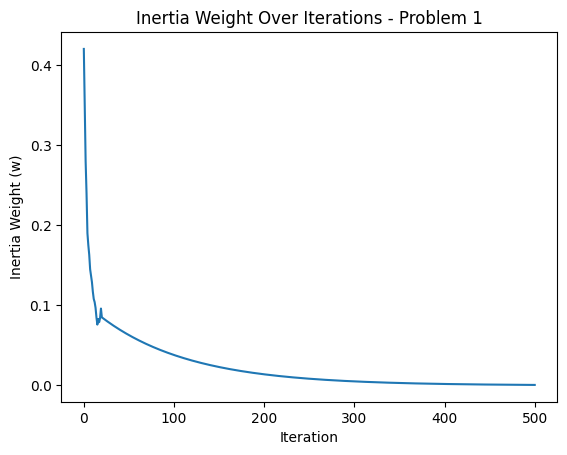

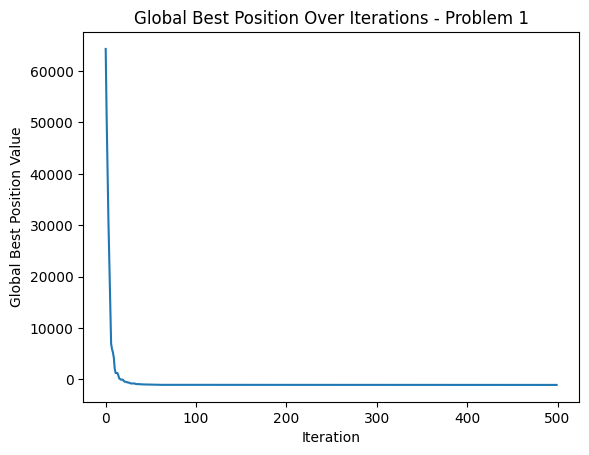




Problem 2 Best Cost: [-701.40936213 -701.42230877 -701.4309541  -701.46580975 -701.48079087
 -701.51648788 -701.55248984 -701.57143434 -701.57143434 -701.58778337
 -701.62156485 -701.63535342 -701.63566328 -701.6578615  -701.66440506
 -701.66843058 -701.66993784 -701.70188295 -701.70415477 -701.71380728
 -701.71380728 -701.72479605 -701.74834643 -701.74834643 -701.76092523
 -701.76092523 -701.76092523 -701.76851277 -701.76851277 -701.78754172
 -701.79808445 -701.80360988 -701.80360988 -701.80360988 -701.80404118
 -701.80970316 -701.82170713 -701.82313657 -701.82313657 -701.82411601
 -701.83779067 -701.83779067 -701.84872216 -701.85860005 -701.85860005
 -701.86468088 -701.86468088 -701.86468088 -701.86468088 -701.87481614
 -701.88432833 -701.88432833 -701.88713092 -701.88713092 -701.88861754
 -701.90535792 -701.90535792 -701.9138745  -701.91518575 -701.91518575
 -701.91518575 -701.91567278 -701.9246143  -701.92963406 -701.92963406
 -701.93306114 -701.94456302 -701.95909611 -701.95909

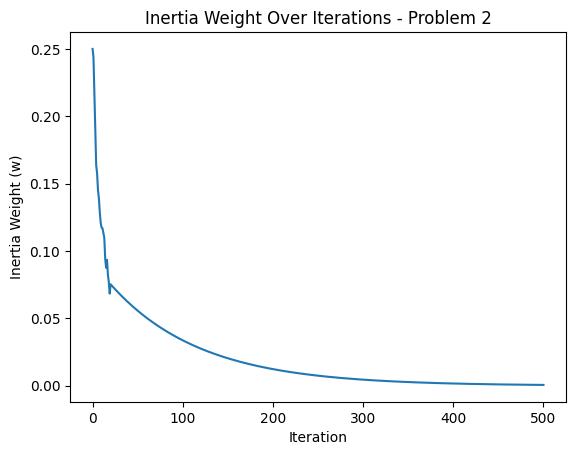

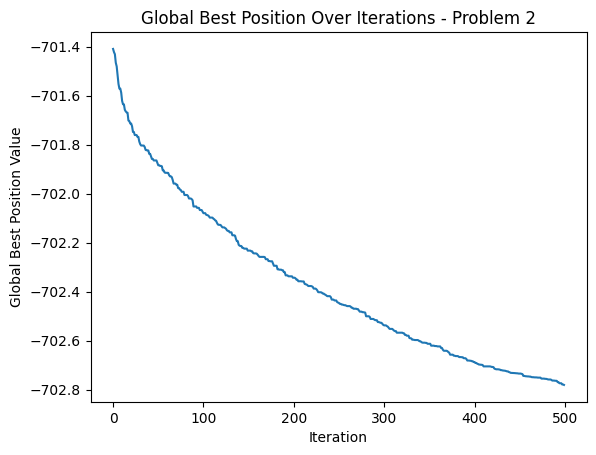




Problem 3 Best Cost: [ 3.64554057e+10  3.26376515e+10  2.64628891e+10  2.17565881e+10
  1.53778699e+10  1.06241030e+10  7.69688244e+09  6.24666935e+09
  5.97338157e+09  5.12384771e+09  4.17690076e+09  2.62208701e+09
  2.12667357e+09  1.88556042e+09  1.87239581e+09  1.47546535e+09
  1.39853505e+09  1.17104117e+09  1.01154339e+09  9.28296191e+08
  6.19479275e+08  6.19479275e+08  5.90156828e+08  4.38055367e+08
  3.47925622e+08  3.10427770e+08  2.87284417e+08  2.87284417e+08
  2.43609171e+08  2.43609171e+08  1.85635397e+08  1.80251756e+08
  1.54734538e+08  1.54734538e+08  1.54734538e+08  1.33256900e+08
  9.31326840e+07  8.90015637e+07  8.21861553e+07  8.21861553e+07
  6.07756479e+07  6.07756479e+07  4.99168457e+07  4.73532004e+07
  4.73532004e+07  4.54981558e+07  4.19778959e+07  3.95707586e+07
  3.95707586e+07  3.13161926e+07  3.13161926e+07  3.13161926e+07
  3.13161926e+07  3.00999515e+07  2.38031924e+07  2.32911072e+07
  1.84871711e+07  1.84871711e+07  1.84871711e+07  1.84871711e+07
 

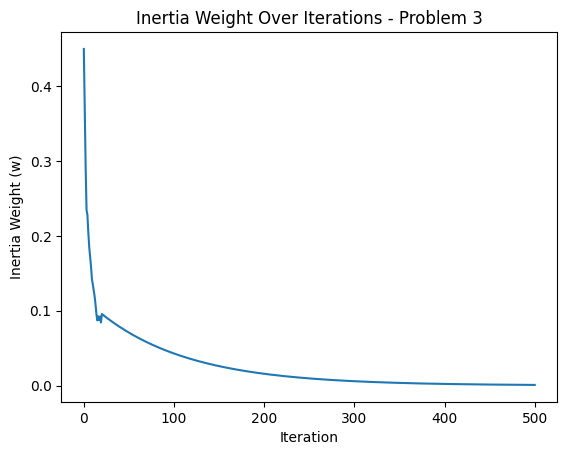

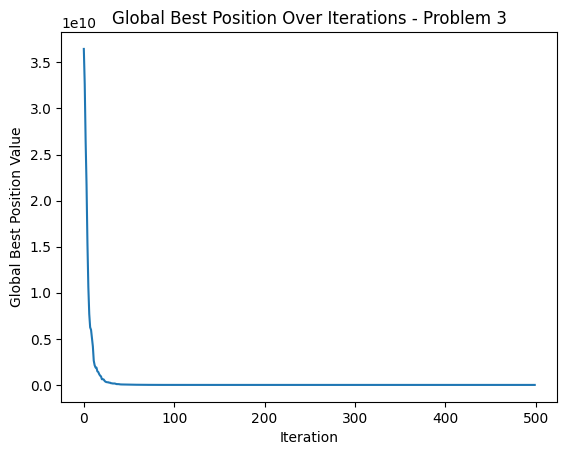




Problem 4 Best Cost: [ 3.03120111e+05  2.38139030e+05  1.69396794e+05  1.39651151e+05
  9.14778851e+04  5.41787027e+04  3.52641225e+04  3.13674275e+04
  2.90991506e+04  2.40922621e+04  1.49258469e+04  1.11046836e+04
  8.48337185e+03  5.89148504e+03  5.36427578e+03  5.25209183e+03
  5.00119859e+03  2.77530039e+03  2.77530039e+03  2.77530039e+03
  2.31792447e+03  2.09610113e+03  2.09610113e+03  2.09397930e+03
  1.88868761e+03  1.82697368e+03  1.69870972e+03  1.69870972e+03
  1.69870972e+03  1.69870972e+03  1.38719991e+03  1.38701683e+03
  1.38701683e+03  1.38701683e+03  1.23993760e+03  9.82976510e+02
  8.61287511e+02  7.87583405e+02  6.68783800e+02  6.68783800e+02
  6.02482613e+02  6.02482613e+02  6.02482613e+02  4.22247698e+02
  3.64315298e+02  3.64315298e+02  2.56582876e+02  2.56582876e+02
  2.56582876e+02  2.56582876e+02  2.56582876e+02  2.56582876e+02
  2.56582876e+02  2.04594393e+02  2.04594393e+02  3.13348317e+01
  1.14291134e+01  1.14291134e+01  1.14291134e+01 -2.05700945e+01
 

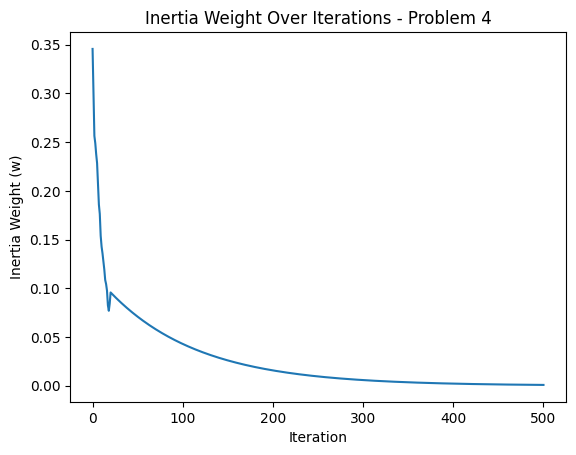

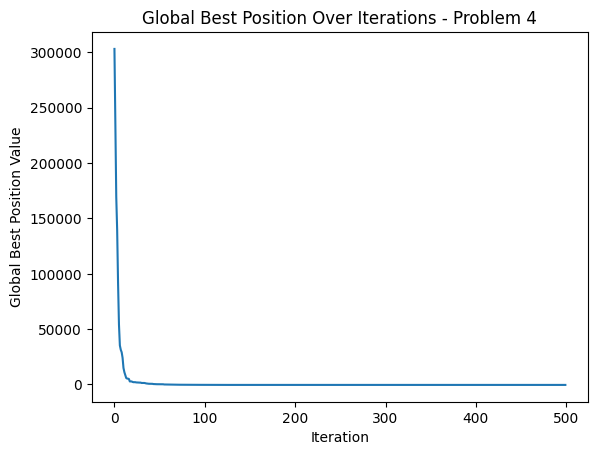




Problem 5 Best Cost: [-334.19229877 -334.23668748 -334.28730978 -334.30175245 -334.33926487
 -334.3914661  -334.44867736 -334.49262065 -334.49589033 -334.53641655
 -334.53641655 -334.54822312 -334.57268801 -334.6068132  -334.62721821
 -334.65829769 -334.68180612 -334.69536789 -334.72975209 -334.736748
 -334.77902721 -334.77902721 -334.79923728 -334.79923728 -334.81866928
 -334.82437938 -334.85265976 -334.85265976 -334.85265976 -334.8556491
 -334.87448208 -334.87448208 -334.89556522 -334.89752114 -334.92104967
 -334.92340291 -334.92340291 -334.93649786 -334.93649786 -334.93649786
 -334.93662025 -334.96739506 -334.96739506 -334.99824234 -334.99824234
 -334.99824234 -335.00968958 -335.00968958 -335.01380983 -335.0185628
 -335.0185628  -335.0185628  -335.0185628  -335.05080753 -335.05080753
 -335.05080753 -335.062142   -335.062142   -335.062142   -335.062142
 -335.06393213 -335.07135048 -335.07678348 -335.09247452 -335.09247452
 -335.09333941 -335.09749792 -335.14513966 -335.15319925 -3

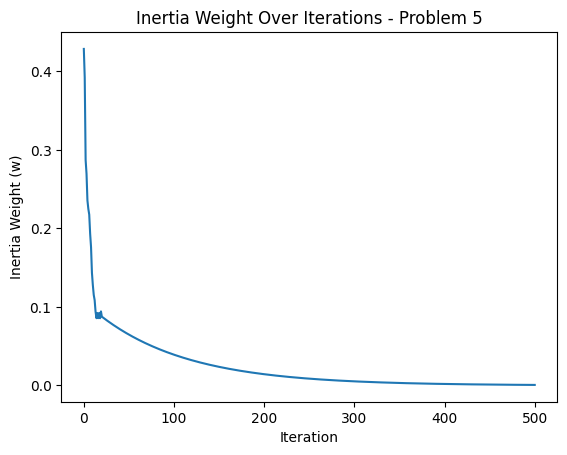

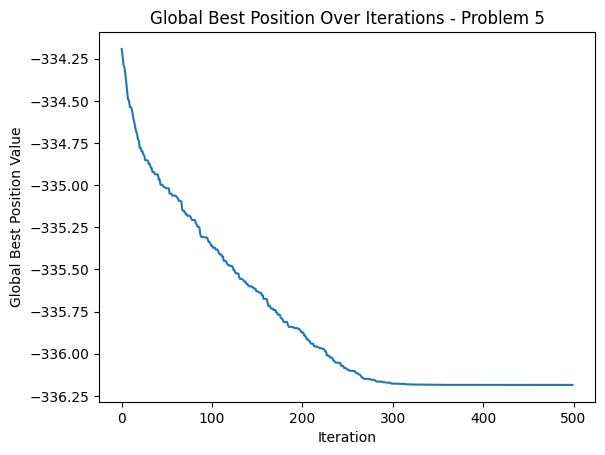




Problem 6 Best Cost: [-183.52692771 -183.57031868 -183.62616785 -183.6406168  -183.71158939
 -183.75955059 -183.85278764 -183.85613639 -183.85801494 -183.88160732
 -183.95247832 -183.96513151 -183.98890831 -183.98890831 -184.04296796
 -184.06215271 -184.06539894 -184.0709802  -184.10345022 -184.13759311
 -184.14598445 -184.14598445 -184.15315282 -184.15315282 -184.16339117
 -184.21006004 -184.23537355 -184.23537355 -184.23537355 -184.24557394
 -184.24557394 -184.24557394 -184.25528705 -184.25528705 -184.27001882
 -184.27001882 -184.27001882 -184.28384987 -184.28996255 -184.29404168
 -184.31525443 -184.34166638 -184.34166638 -184.34166638 -184.34789501
 -184.34789501 -184.34789501 -184.37220862 -184.37547746 -184.3840607
 -184.3840607  -184.40506874 -184.40506874 -184.40506874 -184.41869146
 -184.4253429  -184.42651289 -184.42651289 -184.42651289 -184.4392815
 -184.44660567 -184.45172    -184.45172    -184.46372164 -184.46372164
 -184.46372164 -184.49243868 -184.49243868 -184.4925516

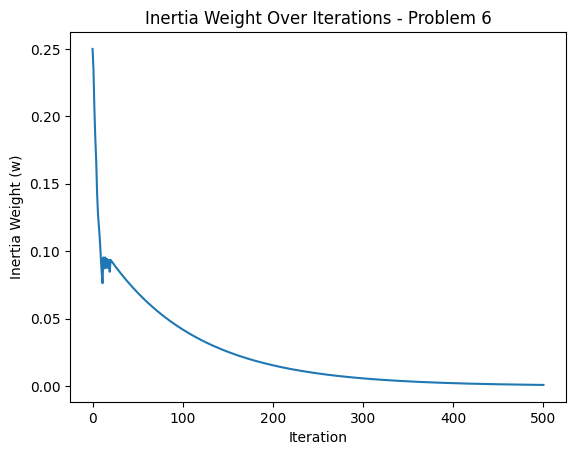

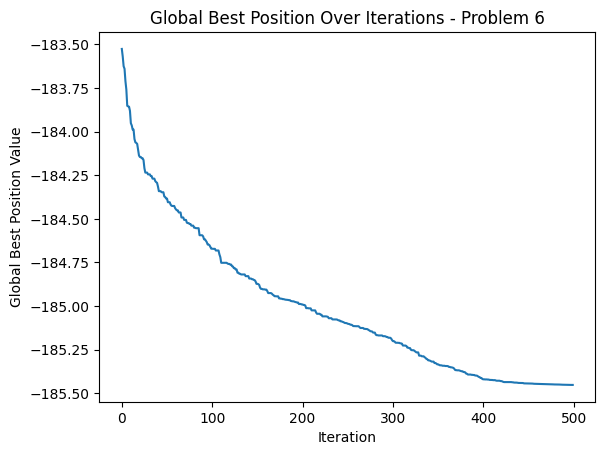




Problem 7 Best Cost: [ 7.91541836e+04  5.23114546e+04  3.98269705e+04  3.35246798e+04
  2.92615805e+04  2.92615805e+04  2.92615805e+04  2.80004064e+04
  2.80004064e+04  2.80004064e+04  2.80004064e+04  2.78698504e+04
  2.72442526e+04  2.24026030e+04  2.07731070e+04  1.39456172e+04
  1.17688311e+04  1.03028862e+04  1.03028862e+04  1.03028862e+04
  8.41099910e+03  8.41099910e+03  8.41099910e+03  8.41099910e+03
  5.69468494e+03  5.69468494e+03  4.86021560e+03  4.69444999e+03
  3.38930817e+03  3.38930817e+03  2.48977423e+03  2.33574156e+03
  2.33574156e+03  2.33574156e+03  2.33574156e+03  2.23811227e+03
  1.91438535e+03  1.86694430e+03  1.38688381e+03  1.38688381e+03
  1.38688381e+03  1.38688381e+03  8.24783791e+02  8.24783791e+02
  8.24783791e+02  8.24783791e+02  7.26810198e+02  7.26810198e+02
  4.83635698e+02  4.72565592e+02  4.72565592e+02  4.28583000e+02
  3.41901328e+02  3.13511739e+02  3.13511739e+02  3.13511739e+02
  3.13511739e+02  2.67317373e+02  2.21130527e+02  1.28371405e+02
 

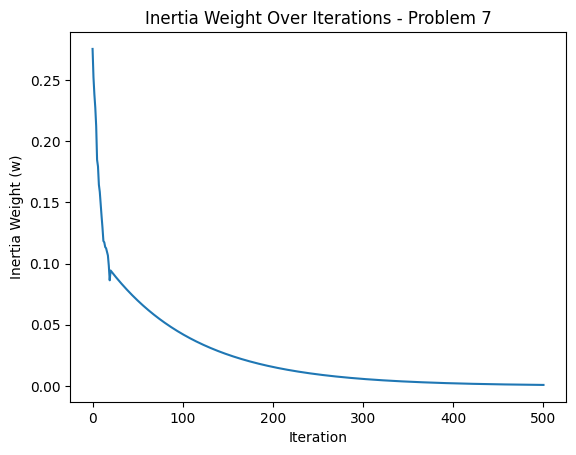

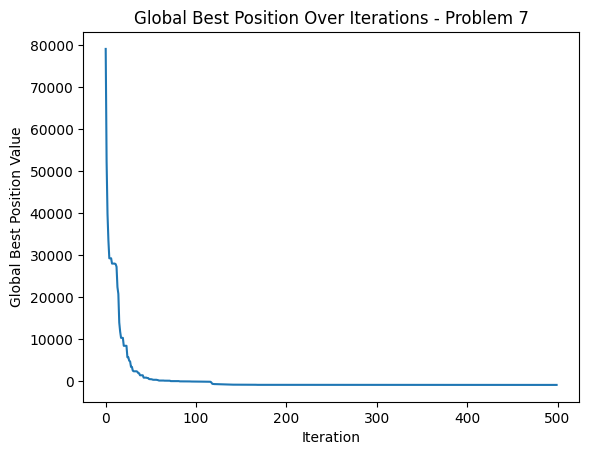




Problem 8 Best Cost: [ 6.58578624e+04  3.02178175e+04  3.02178175e+04  3.02178175e+04
  2.25453972e+04  1.61352778e+04  1.52714272e+04  9.29207601e+03
  9.29207601e+03  9.29207601e+03  9.29207601e+03  9.05913157e+03
  5.75535960e+03  4.77218115e+03  4.77218115e+03  4.77218115e+03
  4.77218115e+03  4.77218115e+03  3.90354990e+03  3.55162165e+03
  3.40084712e+03  2.57423077e+03  2.07285754e+03  2.07285754e+03
  2.07285754e+03  1.42818981e+03  1.29281811e+03  9.26588831e+02
  9.26588831e+02  9.26588831e+02  8.24862791e+02  7.75228983e+02
  6.29871096e+02  4.15049511e+02  4.15049511e+02  4.15049511e+02
  4.15049511e+02  1.04996935e+02  1.04996935e+02  1.04996935e+02
  1.04996935e+02  4.07867524e+01  4.07867524e+01  2.25346271e+01
  2.25346271e+01  2.25346271e+01 -1.08826449e+02 -1.08826449e+02
 -1.08826449e+02 -1.08826449e+02 -1.08826449e+02 -1.82574885e+02
 -2.03826150e+02 -2.03826150e+02 -2.42039353e+02 -3.64547524e+02
 -3.64547524e+02 -3.64547524e+02 -3.64547524e+02 -3.64969031e+02
 

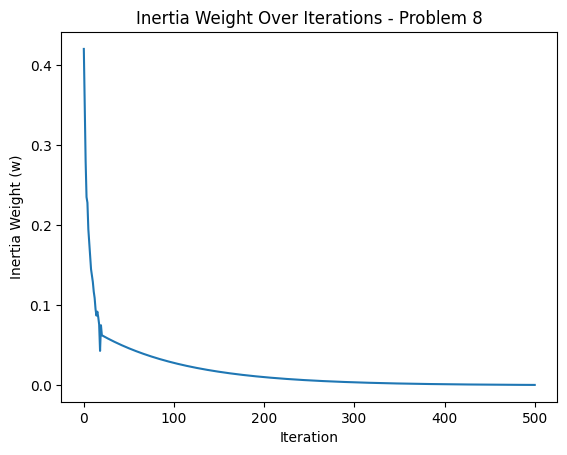

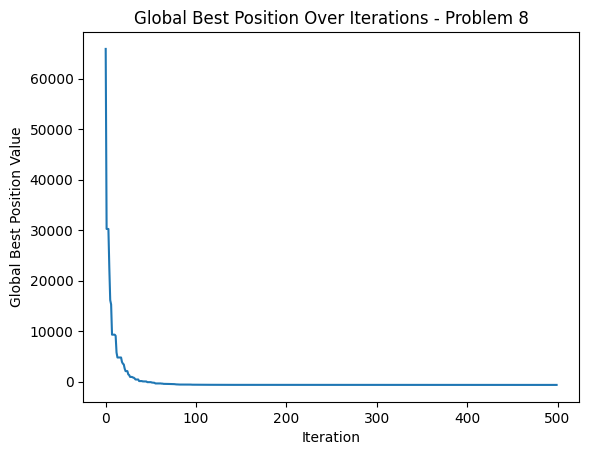




Problem 9 Best Cost: [2.47291797e+05 1.75808959e+05 1.54664435e+05 9.11440924e+04
 9.11440924e+04 9.11440924e+04 8.86339383e+04 8.86339383e+04
 6.29246763e+04 6.29246763e+04 1.43310577e+04 1.43310577e+04
 1.43310577e+04 1.43310577e+04 1.43310577e+04 1.43310577e+04
 1.43310577e+04 1.43310577e+04 1.43310577e+04 1.43310577e+04
 1.43310577e+04 1.43310577e+04 1.43310577e+04 1.43310577e+04
 1.43310577e+04 1.43310577e+04 1.43310577e+04 1.43310577e+04
 8.53918437e+03 6.36962374e+03 6.36962374e+03 5.99561653e+03
 5.99561653e+03 5.99561653e+03 5.99561653e+03 5.99561653e+03
 5.99561653e+03 5.99561653e+03 5.99561653e+03 5.99561653e+03
 5.99561653e+03 5.99561653e+03 3.34327549e+03 3.34327549e+03
 3.34327549e+03 3.34327549e+03 3.16110810e+03 3.16110810e+03
 3.16110810e+03 3.16110810e+03 3.16110810e+03 3.16110810e+03
 2.99357443e+03 2.99357443e+03 2.99357443e+03 2.87699422e+03
 2.87699422e+03 2.87699422e+03 2.83044962e+03 2.83044962e+03
 2.83044962e+03 2.83044962e+03 2.83044962e+03 2.77083632e+03


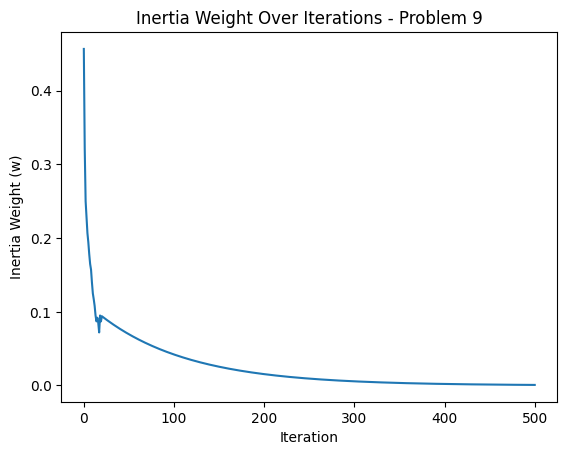

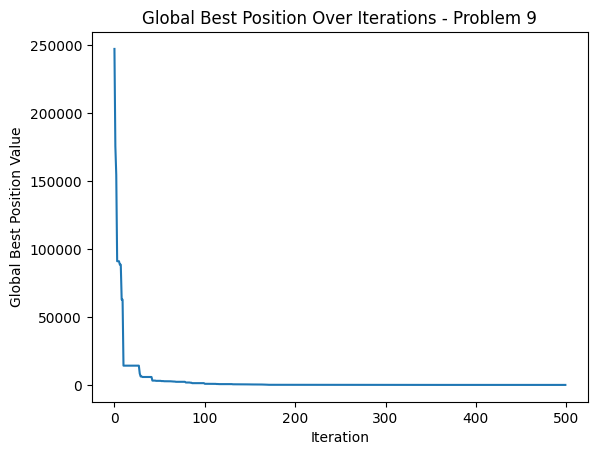




Problem 10 Best Cost: [57161.72752926 44513.31348693 42498.15181869 28985.03666479
 26214.19693644 26214.19693644 26214.19693644 26214.19693644
 21102.80887428 17587.4283771  15541.93561133 15541.93561133
 15541.93561133 15541.93561133 15541.93561133 14426.32777998
 12065.11932342 12065.11932342 11991.54726791  9731.39355917
  8903.97728182  8903.97728182  8903.97728182  8903.97728182
  7563.5973044   7563.5973044   7563.5973044   6855.41483218
  6723.56626838  6723.56626838  6723.56626838  5939.73773638
  5939.73773638  5939.73773638  5713.24905376  5036.49641449
  5036.49641449  5036.49641449  4602.07845352  4602.07845352
  4602.07845352  4602.07845352  3799.26569607  3685.93288413
  3113.81359139  3001.43384734  2310.74582492  2310.74582492
  2310.74582492  2310.74582492  2310.74582492  2310.74582492
  2263.96520917  2023.80832988  2023.80832988  1907.81069395
  1907.81069395  1757.39216011  1757.39216011  1757.39216011
  1757.39216011  1757.39216011  1752.53608159  1625.98885129

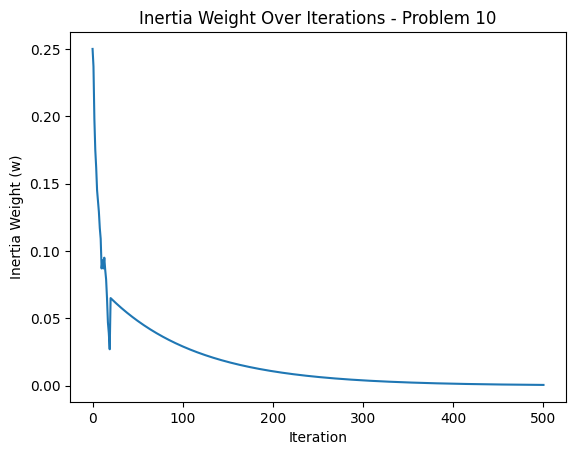

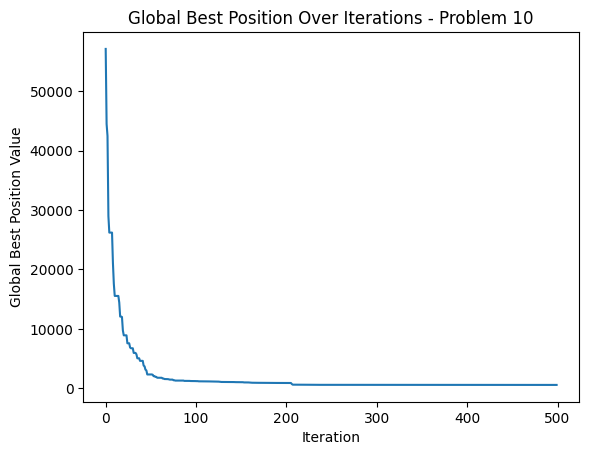




Problem 11 Best Cost: [ 5.50579511e+04  5.02240772e+04  3.55756062e+04  2.96843984e+04
  2.37594014e+04  2.37594014e+04  2.17783463e+04  2.17783463e+04
  2.17783463e+04  1.92709950e+04  1.48669728e+04  1.10777950e+04
  8.83562672e+03  8.07427656e+03  6.95261205e+03  6.19467306e+03
  4.06195408e+03  2.97031534e+03  2.97031534e+03  1.93260596e+03
  1.93260596e+03  1.93260596e+03  1.71013500e+03  1.71013500e+03
  1.71013500e+03  1.57378604e+03  1.57378604e+03  1.57378604e+03
  1.57378604e+03  1.57378604e+03  1.45909630e+03  1.45909630e+03
  1.38802304e+03  9.62866273e+02  9.62866273e+02  9.62866273e+02
  9.62866273e+02  8.47734494e+02  8.05110126e+02  8.05110126e+02
  7.31887592e+02  7.26538712e+02  7.26538712e+02  6.95125173e+02
  6.95125173e+02  6.95125173e+02  6.95125173e+02  6.94819736e+02
  4.64536420e+02  4.64536420e+02  4.64536420e+02  4.64536420e+02
  4.64536420e+02  4.64536420e+02  4.64536420e+02  4.64536420e+02
  4.19224968e+02  4.19224968e+02  4.17787281e+02  3.67732413e+02


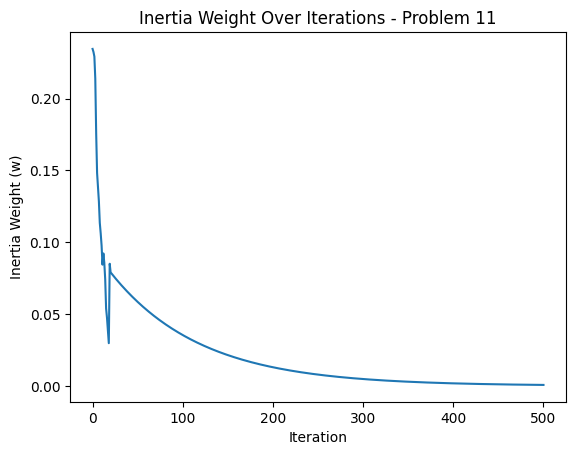

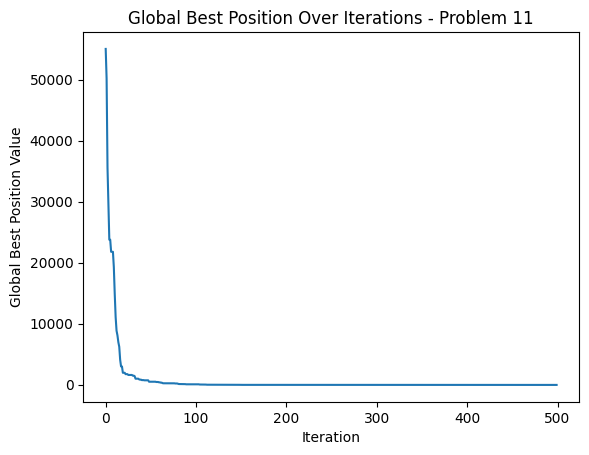




Problem 12 Best Cost: [55150.52053591 31341.94273214 31341.94273214 30362.07806952
 30362.07806952 29668.64555584 29668.64555584 29668.64555584
 27888.52864165 24838.77597065 24838.77597065 24838.77597065
 24793.33184655 21222.42120354 19452.52614809 19452.52614809
 16515.53236375 16295.10162036 16295.10162036 15785.24681557
 15785.24681557 15785.24681557 15785.24681557 15785.24681557
 15785.24681557 15785.24681557 14892.63091644 14840.25718374
 13150.03320543 12826.96107607 12760.74422409 12760.74422409
 11465.75083545 11465.75083545 11465.75083545 11465.75083545
 11465.75083545 11465.75083545  9604.60312706  9604.60312706
  9604.60312706  9604.60312706  9604.60312706  9604.60312706
  9604.60312706  9604.60312706  9604.60312706  9604.60312706
  9604.60312706  9604.60312706  9604.60312706  9604.60312706
  9604.60312706  9604.60312706  9604.60312706  9604.60312706
  9604.60312706  9604.60312706  9142.61568071  9142.61568071
  8898.56343963  8898.56343963  8898.56343963  8388.34132456

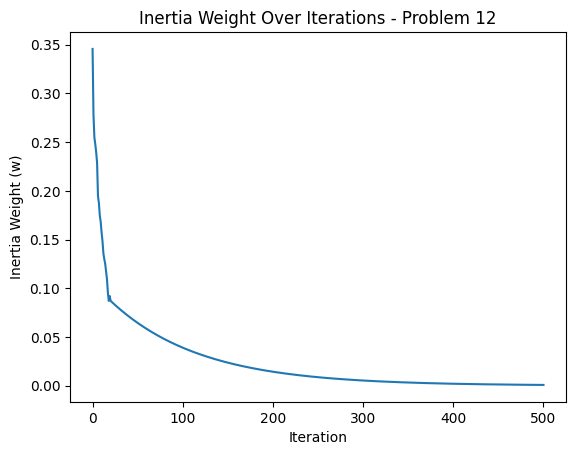

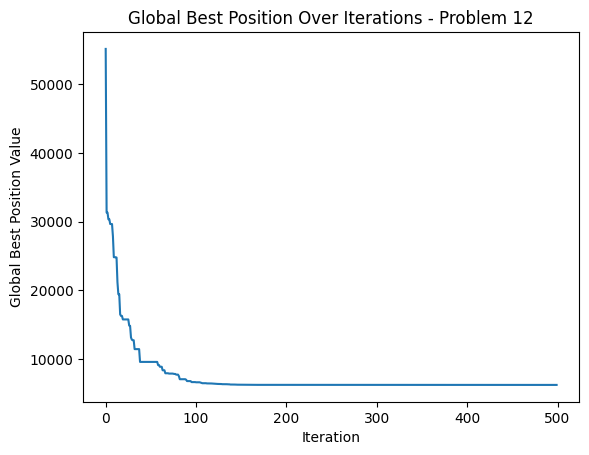




Problem 13 Best Cost: [182752.89805797 182752.89805797 156454.02091108 156454.02091108
 156454.02091108 156454.02091108 156454.02091108 156454.02091108
 156454.02091108 134480.28171413  71244.44774978  71244.44774978
  71244.44774978  71244.44774978  71244.44774978  71244.44774978
  71244.44774978  71244.44774978  71244.44774978  71244.44774978
  71244.44774978  71244.44774978  71244.44774978  71244.44774978
  71244.44774978  43073.91225494  43073.91225494  43073.91225494
  43073.91225494  43073.91225494  43073.91225494  43073.91225494
  43073.91225494  43073.91225494  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  21432.25801352
  21432.25801352  21432.25801352  21432.25801352  17258.22037959


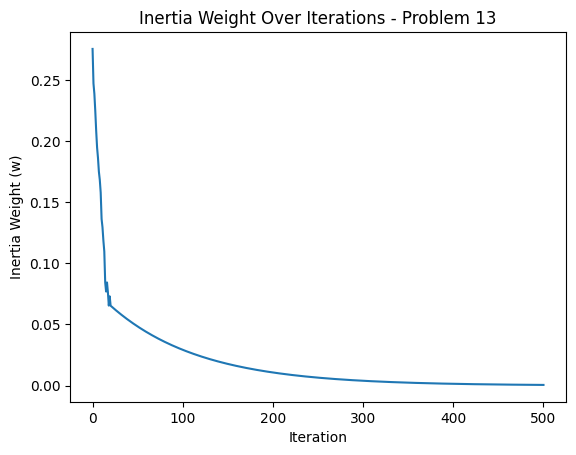

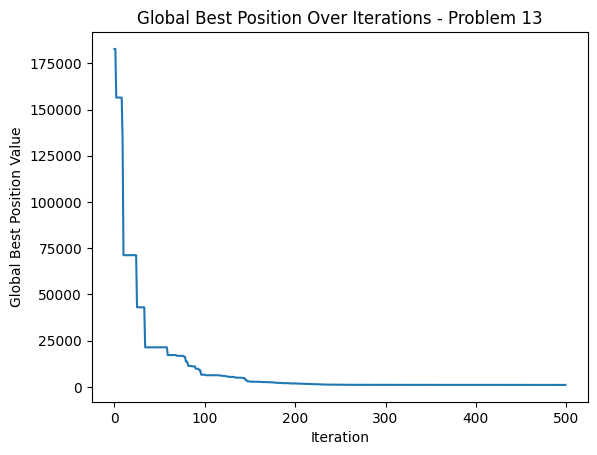




Problem 14 Best Cost: [38143.37784274 33083.43047837 27863.2142038  24862.87760034
 24862.87760034 24545.22712376 24273.05649511 22621.14099453
 19030.05373462 15790.5198168  15790.5198168  15790.5198168
 15488.65756078 15488.65756078 13534.87356593 13534.87356593
 13534.87356593 13532.09355666 13532.09355666 13305.90776421
 11760.4193257  10395.60702933 10395.60702933 10395.60702933
 10252.38412727 10252.38412727 10252.38412727 10252.38412727
 10252.38412727 10252.38412727 10252.38412727 10252.38412727
 10252.38412727 10252.38412727 10252.38412727 10252.38412727
 10252.38412727 10252.38412727 10129.30054608 10129.30054608
 10129.30054608 10129.30054608 10129.30054608 10129.30054608
 10129.30054608  9750.99780611  9750.99780611  9750.99780611
  9750.99780611  9750.99780611  9750.99780611  9332.31554303
  9332.31554303  9332.31554303  9332.31554303  9332.31554303
  9332.31554303  9332.31554303  9332.31554303  9332.31554303
  9332.31554303  9332.31554303  9324.58244934  9324.58244934


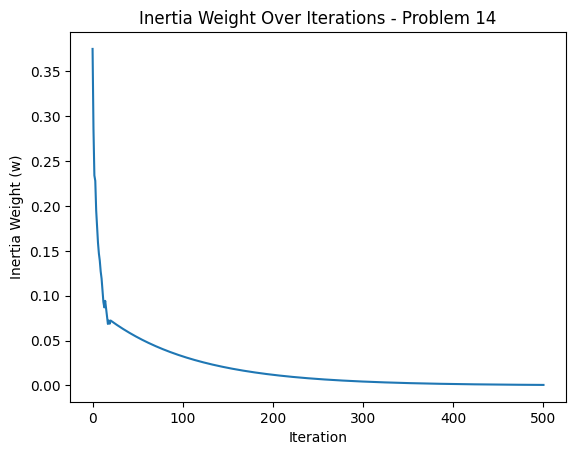

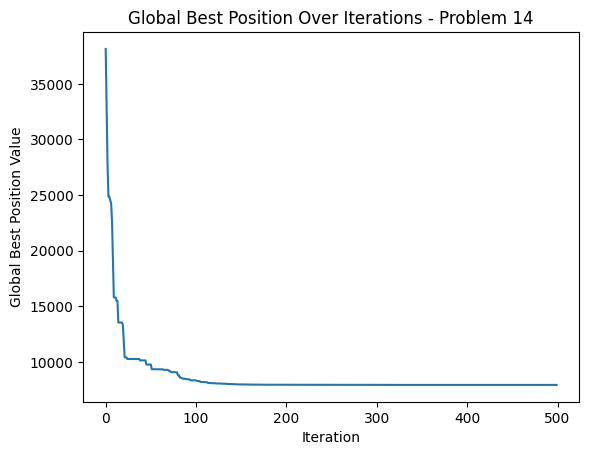




Problem 15 Best Cost: [-225.03395028 -225.03395028 -225.03395028 -225.03395028 -225.03395028
 -225.38540864 -225.38540864 -225.38540864 -225.38540864 -225.38540864
 -225.38540864 -225.46074648 -225.48310209 -225.48310209 -225.48310209
 -225.48310209 -226.47283531 -226.47283531 -226.47283531 -226.47283531
 -226.47283531 -226.51136799 -226.51136799 -226.54353493 -226.54353493
 -226.54353493 -226.68233804 -226.68233804 -226.68233804 -226.68233804
 -226.68233804 -226.68233804 -226.68233804 -226.74621913 -226.76138945
 -227.0088253  -227.02204621 -227.02204621 -227.12643772 -227.12643772
 -227.12643772 -227.12643772 -227.12643772 -227.15437123 -227.26701231
 -227.26701231 -227.31571328 -227.31571328 -227.31571328 -227.39940693
 -227.39940693 -227.39940693 -227.39940693 -227.39940693 -227.4297692
 -227.4297692  -227.4297692  -227.45892512 -227.45892512 -227.45892512
 -227.5222498  -227.5222498  -227.5222498  -227.5222498  -227.52739315
 -227.52739315 -227.52739315 -227.52739315 -227.56804

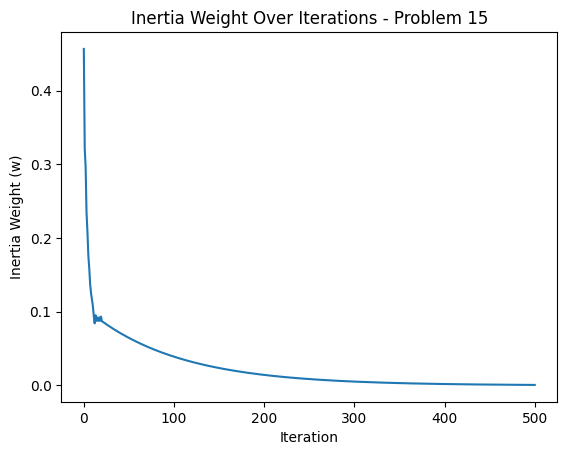

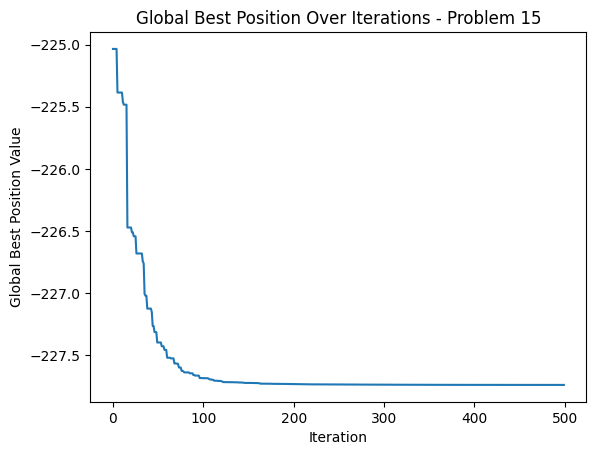




Problem 16 Best Cost: [49788.96250808 36046.06032305 28372.18497266 18509.54839108
 12250.13876893  9179.03629012  4396.07400372  3040.00744958
  1592.40714862   268.06261232 -2158.12588915 -2158.12588915
 -2158.12588915 -2158.12588915 -2461.77652946 -3045.92042997
 -3689.95414554 -3877.36545607 -3877.36545607 -3899.12052594
 -3899.12052594 -4046.08580221 -4095.13392329 -4133.07262404
 -4238.72618534 -4334.95032021 -4334.95032021 -4358.01897683
 -4358.01897683 -4358.01897683 -4577.46506429 -4676.16410157
 -4676.16410157 -4676.16410157 -4735.85943396 -4752.85762988
 -4752.85762988 -4771.02402136 -4771.02402136 -4771.02402136
 -4816.72034801 -4816.72034801 -4816.72034801 -4873.65590173
 -4873.65590173 -4873.65590173 -4873.65590173 -4895.15028166
 -4895.15028166 -4895.15028166 -4897.44690979 -4897.44690979
 -4897.44690979 -4911.7199302  -4911.7199302  -4927.61497661
 -4932.18382546 -4940.59419924 -4947.57035262 -4947.57035262
 -4955.28620449 -4955.28620449 -4958.9778159  -4963.83107666

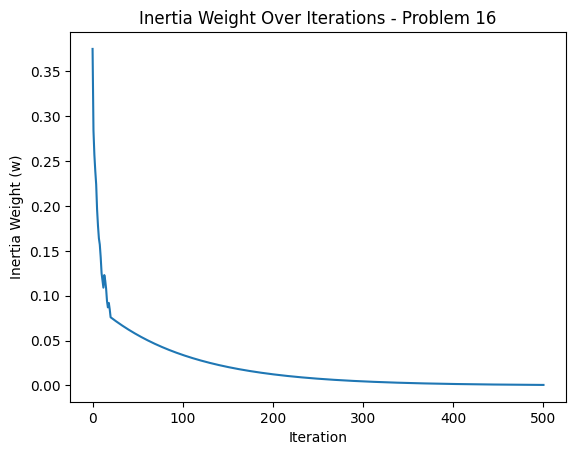

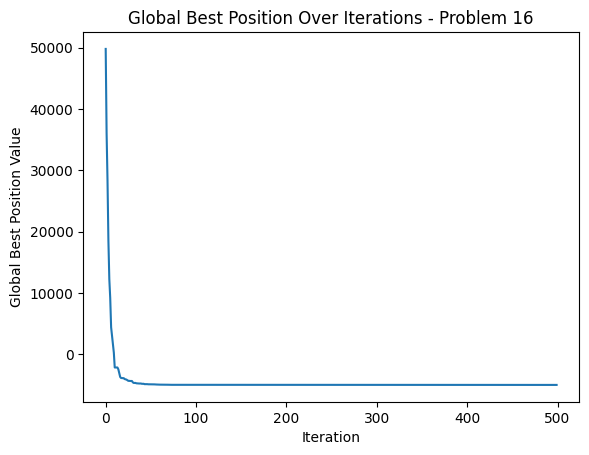




Problem 17 Best Cost: [ 3.39819477e+06  3.00891394e+06  2.40895430e+06  1.87690062e+06
  1.56293025e+06  1.08941139e+06  7.76813807e+05  5.95343167e+05
  5.87342997e+05  4.46107509e+05  3.39588046e+05  3.03927534e+05
  2.90658099e+05  2.14767397e+05  2.08580971e+05  1.62412131e+05
  1.34208296e+05  9.91395693e+04  9.91395693e+04  9.91395693e+04
  9.76747626e+04  8.72136818e+04  6.22408258e+04  6.07643033e+04
  6.07643033e+04  5.23312989e+04  5.06461347e+04  5.06461347e+04
  5.06461347e+04  3.32079661e+04  3.32079661e+04  3.13629303e+04
  3.13629303e+04  2.71549833e+04  2.21774919e+04  2.05461731e+04
  2.05461731e+04  2.05461731e+04  2.05461731e+04  2.05461731e+04
  1.63013914e+04  1.63013914e+04  1.49338634e+04  1.49338634e+04
  1.25377091e+04  1.04405643e+04  1.03419136e+04  9.27355893e+03
  6.80846926e+03  5.11052344e+03  5.11052344e+03  4.35788911e+03
  4.10378860e+03  3.14297310e+03  3.14297310e+03  3.14297310e+03
  2.35665926e+03  2.33807842e+03  9.77836190e+02  9.77836190e+02


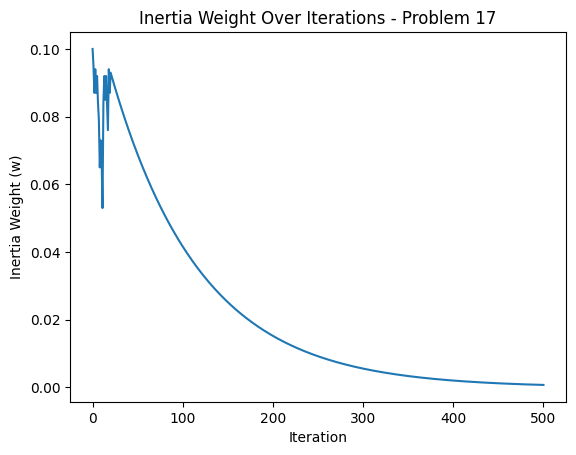

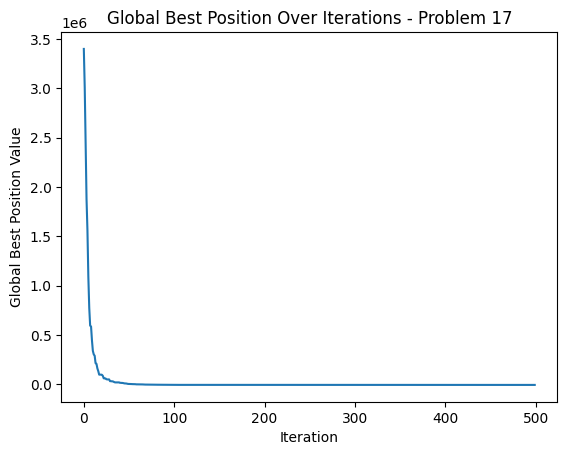




Problem 18 Best Cost: [69864.38463918 48768.42242134 41476.90249901 33827.55263252
 31665.92834443 31665.92834443 30226.07831397 27906.72630052
 27906.72630052 27906.72630052 27906.72630052 24541.72747119
 24541.72747119 24541.72747119 24541.72747119 24541.72747119
 24541.72747119 24541.72747119 23569.07960154 23569.07960154
 23569.07960154 23569.07960154 23569.07960154 22033.7301278
 22033.7301278  21676.73110375 21676.73110375 21676.73110375
 21676.73110375 21676.73110375 21676.73110375 17868.89670327
 17868.89670327 17868.89670327 17868.89670327 17868.89670327
 17868.89670327 17868.89670327 17868.89670327 17257.11570405
 17257.11570405 17257.11570405 15785.36825116 15785.36825116
 15785.36825116 15785.36825116 15142.38563465 15142.38563465
 15142.38563465 15142.38563465 15142.38563465 15142.38563465
 15142.38563465 15142.38563465 14122.75563899 14122.75563899
 14122.75563899 14122.75563899 14122.75563899 14122.75563899
 14122.75563899 14122.75563899 14122.75563899 14122.75563899


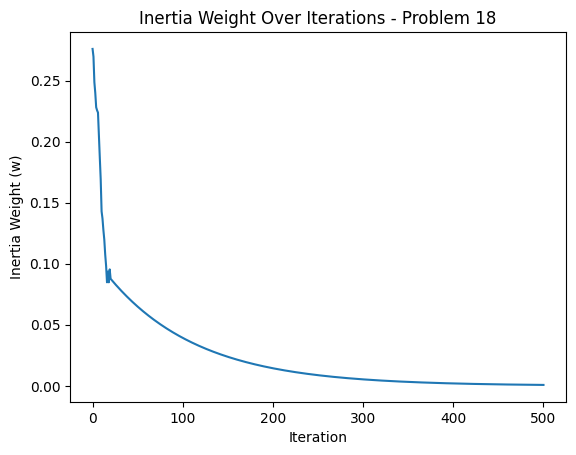

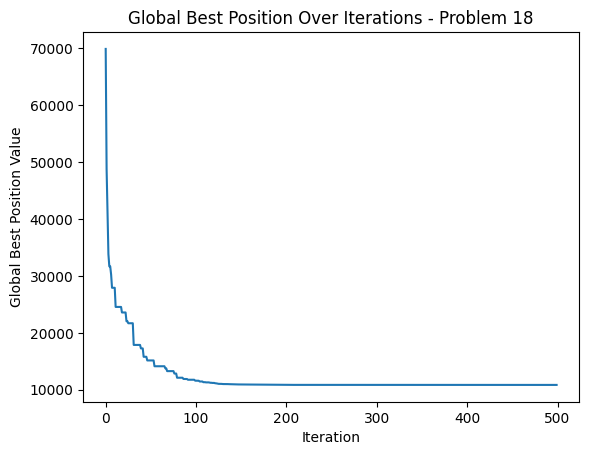




Problem 19 Best Cost: [64738.06843639 46448.76357407 40101.13624575 34817.67298204
 29426.94799892 29426.94799892 29426.94799892 29426.94799892
 28427.26153645 25983.23530523 25983.23530523 25983.23530523
 25983.23530523 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 18102.01424182 18102.01424182 18102.01424182 18102.01424182
 17184.14921518 17184.14921518 17184.14921518 17184.14921518
 17184.14921518 17184.14921518 17184.14921518 17184.14921518
 17184.14921518 17184.14921518 17184.14921518 17184.14921518
 17184.14921518 17184.14921518 17184.14921518 17184.14921518
 17184.14921518 17184.14921518 17184.14921518 17184.14921518

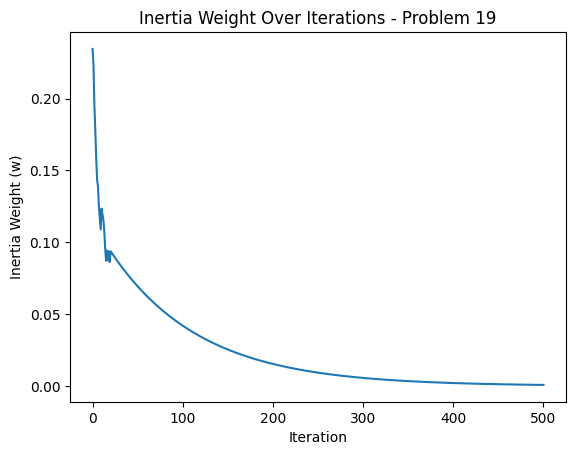

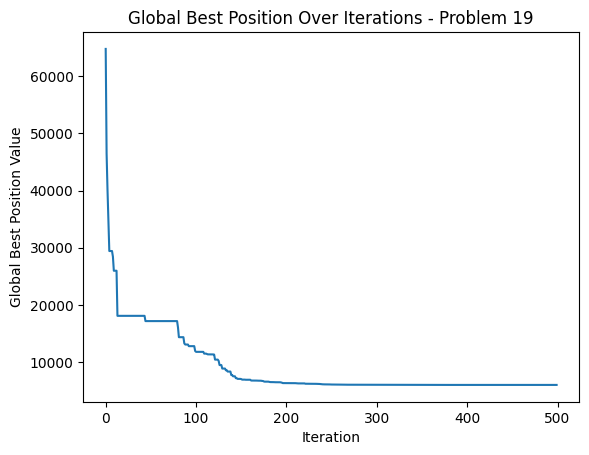




Problem 20 Best Cost: [-84.07798651 -84.48144088 -84.59298436 -85.02338351 -85.02338351
 -85.29167736 -85.73599856 -85.99859035 -86.33134059 -86.78033082
 -86.97766274 -86.97766274 -86.97766274 -87.20650824 -87.46646676
 -87.46646676 -87.46646676 -87.72349846 -87.72349846 -87.72349846
 -87.72349846 -87.72349846 -87.91442415 -88.23065917 -88.63853362
 -88.63853362 -88.64495024 -88.64495024 -88.64495024 -88.64495024
 -88.64495024 -88.64495024 -88.64495024 -88.64495024 -88.64495024
 -88.64495024 -88.64495024 -88.64495024 -88.64495024 -88.64495024
 -88.64495024 -88.64495024 -88.89263123 -88.89263123 -88.89263123
 -88.93623514 -88.96438097 -88.96438097 -88.96438097 -88.96438097
 -88.96438097 -88.96438097 -88.96438097 -88.96438097 -89.06561938
 -89.06561938 -89.06561938 -89.06561938 -89.06561938 -89.06561938
 -89.06561938 -89.06561938 -89.06561938 -89.06561938 -89.07659604
 -89.12493003 -89.12493003 -89.15278232 -89.15278232 -89.16990403
 -89.22006924 -89.22006924 -89.22006924 -89.2200692

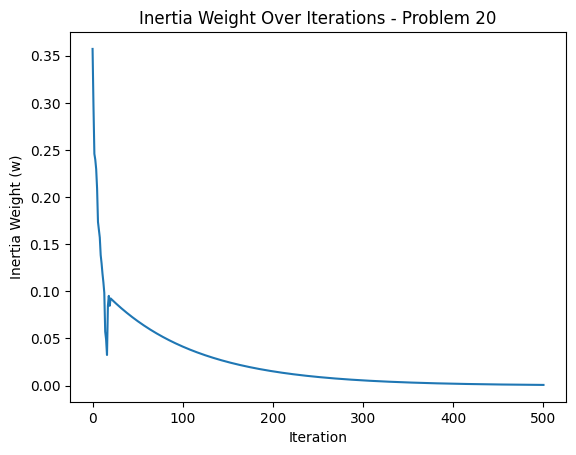

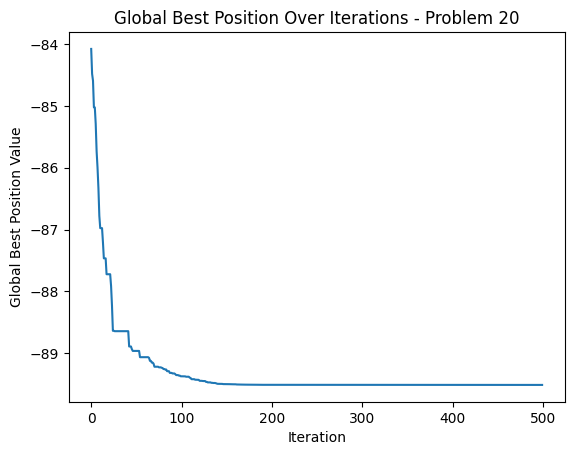




Problem 21 Best Cost: [156.45514066 108.71526907  53.21603746  13.88959795  13.88959795
  11.13052056   5.51012864  -1.72121727  -1.72121727  -1.72121727
  -4.90863725  -9.16166754  -9.16166754 -11.24677299 -11.62433483
 -11.62433483 -11.88605642 -11.88605642 -11.95366641 -13.2518253
 -13.2518253  -13.2518253  -13.2518253  -18.08921325 -20.19888776
 -20.19888776 -20.19888776 -20.19888776 -20.61732139 -21.38015091
 -23.35932308 -24.69230426 -24.69230426 -24.69230426 -24.69230426
 -25.54505847 -25.54505847 -25.54505847 -25.74300321 -26.13368578
 -27.97316276 -28.03557226 -28.24663491 -30.42962897 -30.42962897
 -30.42962897 -31.27192783 -31.27192783 -31.71861563 -31.71861563
 -31.71861563 -31.71861563 -32.16690594 -32.62678854 -32.62678854
 -33.33017229 -33.72534249 -33.72534249 -34.44446932 -34.44446932
 -34.88661968 -34.89293041 -34.89293041 -35.3314786  -35.3314786
 -35.3314786  -35.91958159 -36.47472688 -36.47472688 -36.61434654
 -36.61434654 -36.61434654 -37.06731417 -37.06731417 

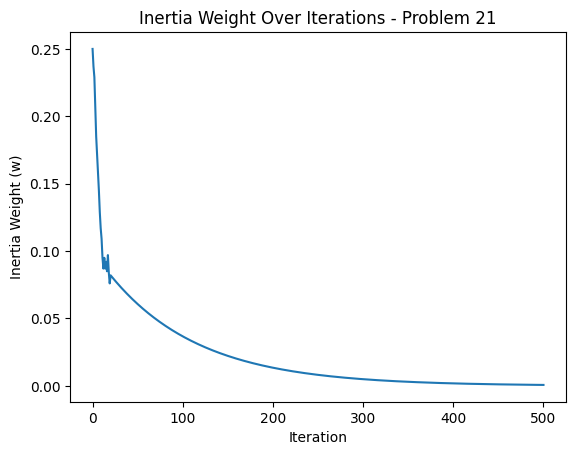

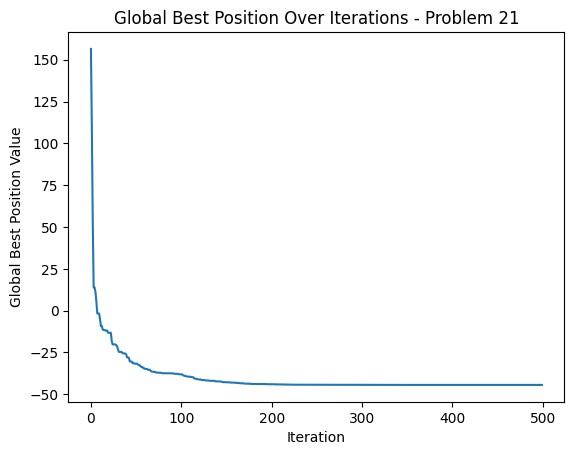




Problem 22 Best Cost: [270042.87292948 262968.51833904 259898.2280418  204636.1906684
 204636.1906684  204636.1906684  195465.17740035 195465.17740035
 190006.55369404 190006.55369404 190006.55369404 190006.55369404
 190006.55369404 190006.55369404 190006.55369404 170503.47192783
 169109.01914799 169109.01914799 169109.01914799 169109.01914799
 169109.01914799 162136.50823978 162136.50823978 162136.50823978
 162136.50823978 159641.97738915 159641.97738915 148831.68921134
 148831.68921134 148831.68921134 148831.68921134 148831.68921134
 148831.68921134 148831.68921134 148831.68921134 148831.68921134
 148831.68921134 148831.68921134 148831.68921134 148831.68921134
 148831.68921134 148831.68921134 148831.68921134 132463.55125223
 132463.55125223 122449.27301055 122449.27301055 122449.27301055
 122449.27301055 122449.27301055 122449.27301055 122449.27301055
 118105.24870447 105706.88623411 105706.88623411 105706.88623411
 105706.88623411 104472.66744653 104472.66744653 104472.66744653
 

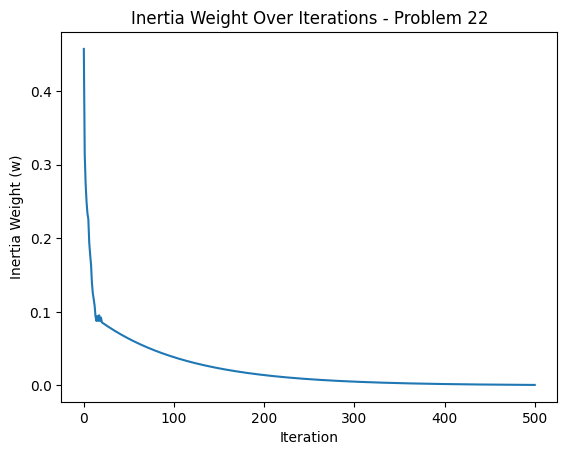

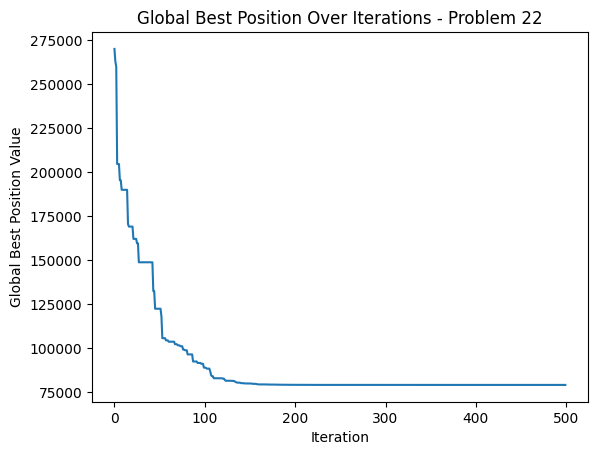




Problem 23 Best Cost: [-24.02808396 -24.02808396 -24.02808396 -24.58337184 -24.58337184
 -24.58337184 -32.09837586 -32.09837586 -36.77093311 -36.77093311
 -36.77093311 -36.77093311 -38.29469152 -41.16256955 -41.16256955
 -41.16256955 -41.16256955 -41.16256955 -41.16256955 -43.33971098
 -43.33971098 -43.33971098 -43.33971098 -43.33971098 -44.00003166
 -44.00003166 -44.00003166 -44.00003166 -44.00003166 -44.00003166
 -44.32695542 -48.49848366 -48.49848366 -48.49848366 -48.56057703
 -48.56057703 -48.56057703 -48.56057703 -49.65346358 -49.65346358
 -51.91772017 -51.91772017 -51.91772017 -51.91772017 -51.91772017
 -51.91772017 -51.91772017 -51.91772017 -52.60560097 -53.94410377
 -53.94410377 -53.94410377 -53.94410377 -53.94410377 -53.94410377
 -53.94410377 -53.94410377 -53.94410377 -54.22878721 -54.22878721
 -54.22878721 -54.65080414 -54.73888901 -55.45205605 -55.45205605
 -55.45205605 -55.45205605 -55.45205605 -55.46438016 -56.43953426
 -56.43953426 -56.43953426 -56.67377533 -56.6737753

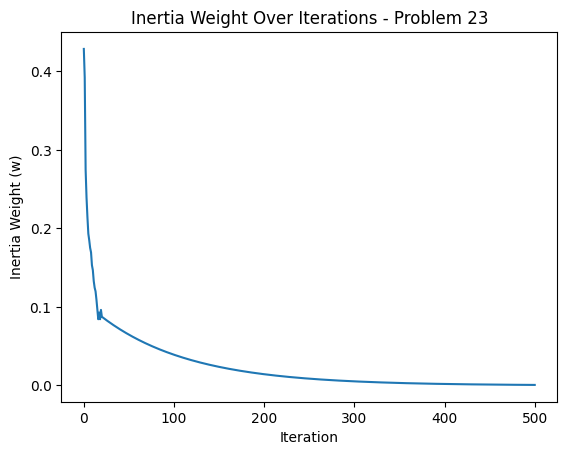

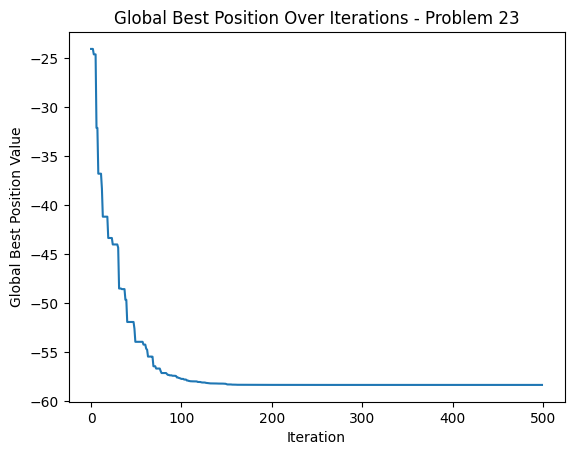




Problem 24 Best Cost: [112.96559239 112.60307946 112.60307946  97.09026796  79.84349064
  79.84349064  79.84349064  79.84349064  79.84349064  79.84349064
  79.84349064  73.2993439   73.2993439   73.2993439   73.2993439
  71.38095285  71.38095285  70.74224281  70.74224281  70.74224281
  70.74224281  70.74224281  70.74224281  69.53095844  61.76399505
  61.76399505  61.76399505  61.76399505  61.76399505  61.76399505
  61.76399505  61.76399505  61.76399505  61.76399505  61.76399505
  61.76399505  60.55830945  60.55830945  60.55830945  60.55830945
  60.55830945  60.55830945  60.55830945  59.67460663  59.67460663
  58.79457163  58.79457163  58.67940695  58.67940695  58.67940695
  58.67940695  58.67940695  58.67940695  54.06185287  54.06185287
  54.06185287  54.06185287  52.9984998   52.9984998   52.9984998
  52.9984998   51.54342007  50.67071829  50.67071829  50.67071829
  50.67071829  47.29433913  47.29433913  46.67936798  46.67936798
  46.67936798  46.67936798  46.67936798  46.67936798 

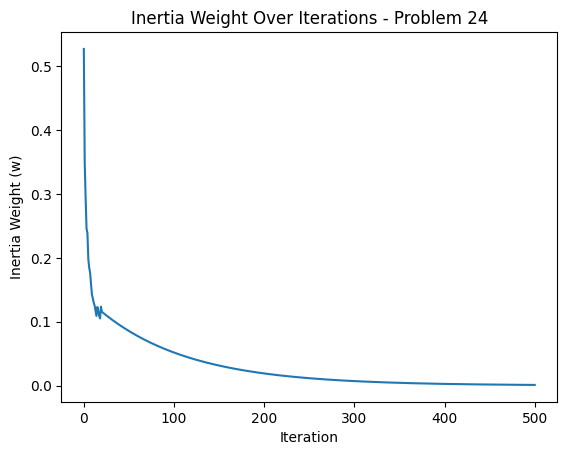

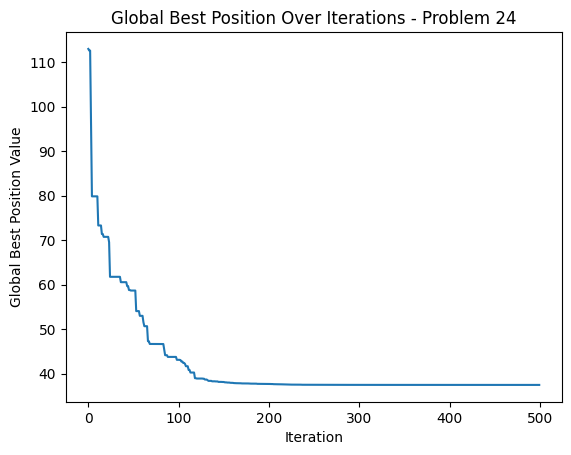

In [30]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [31]:
print('nice')

nice


In [32]:
print('almost complete')

almost complete


In [33]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [34]:
ok

NameError: name 'ok' is not defined